# Some maybe usefull stuff:
- Lets keep all the question to Antonio to trello
- The code to mark text: $**<code style="background:yellow;color:blue"> text</code>**$

In [381]:
# pip install -U imbalanced-learn

# 1. Importing dependencies and data

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import streamlit as st
import os
import time

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataCleaner(BaseEstimator, TransformerMixin):
    '''The DataCleaner class is a custom transformer that can be used to clean and preprocess data in a machine learning pipeline.

    The class has several parameters:
        - hour: a boolean parameter that indicates whether to convert the Time feature to hours and one-hot-encode the resulting hour feature (default True)
        - feature_to_drop: a list of feature names to drop from the DataFrame (default [])
        - labels: a boolean parameter that indicates whether to split the Class feature (if it exists) from the other features and store it separately (default True)
        - imputer: an imputer object from scikit-learn to use for imputing missing values in the DataFrame (default None)
        - scaler: a scaler object from scikit-learn to use for scaling the numerical features in the DataFrame (default None)

    
    The class implements two methods, fit and transform. The functions takes data argument which must be a DataFrame'''

    def __init__(self, hour:bool =True, feature_to_drop:list =[], labels:bool =True, imputer:str = None, \
                 amount_scaler:str = None, time_scaler:str = None, amount_log:bool = False):
        self.hour = hour
        self.feature_to_drop = feature_to_drop
        self.labels = labels
        self.imputer = imputer
        self.amount_scaler = amount_scaler
        self.time_scaler = time_scaler
        self.labels_data = None
        self.time = ['Time']
        self.amount = ['Amount']
        self.amount_log = amount_log
#         self.data_num = ['Amount'] # other columns have been already scaled.
        
        
    def fit(self, data, y=None):
        if self.imputer:
            self.imputer.fit(data)
        
        if self.amount_scaler:
            self.amount_scaler.fit(data.loc[:,self.amount])
            
        if self.time_scaler:
            self.time_scaler.fit(data.loc[:,self.time])
            
        
        return self #, self.imputer, self.scaler
    
    def transform(self, data, y=None):
        # make a copy of the input data
        data = data.copy()
        
        # Dropping all the rows where "Class" is missing
        if 'Class' in data.columns:
            data = data.dropna(axis=0, subset = 'Class')
        
        # log transform amount
        if self.amount_log == True:
            data['Amount'] = np.log1p(data['Amount'])
            
        #Imputing missing_values 
        if data.isnull().values.any() or data.isna().values.any():
            data = pd.DataFrame(self.imputer.transform(data), columns=data.columns)
                
       
        # Spliting labels from other features (if the data includes column 'Class'):
        if self.labels:
            if 'Class' in data.columns:
                self.labels_data = data['Class']
                data = data.drop('Class', axis=1)
                
            else:
                raise ValueError("No target variable 'Class' found in the dataset")
        labels_data = self.labels_data

        if self.amount_scaler:
            data_amount_scaled = self.amount_scaler.transform(data.loc[:,self.amount])
            data.loc[:,self.amount] = data_amount_scaled
            
        if self.time_scaler:
            data_time_scaled = self.time_scaler.transform(data.loc[:,self.time])
            data.loc[:,self.time] = data_time_scaled


        # Converting 'Time' to 'hours':
        if self.hour:
            if 'Time' in data.columns:
                data['hour'] = ((((data['Time']) // (60 * 60)) % 24) + 1)
                data['hour'] = data['hour'].astype(int)
                data = data.drop('Time', axis=1)
            
                # one-hot-encoded dataset
                data = pd.get_dummies(data, columns=['hour'], prefix='hour')
            else:
                print("No 'Time' variable in the dataset")

        # Dropping not needed features based on the feature_to_drop list
        if self.feature_to_drop:
            data = data.drop(self.feature_to_drop, axis=1)
        
        
        return data, labels_data

In [3]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)

In [4]:
#Getting the data

# raw_data = pd.read_csv(r"C:\Users\katar\OneDrive\Dokumenty\Edukacja\Data Science\6_DS_Project\Project\03_Coding\Cards_data\creditcard.csv")

raw_data = pd.read_csv(r"D:\06_projekt_i_data_science\coding ground\raw data\creditcard.csv")

# 2. Sanity checking the WHOLE dataset

In [39]:
raw_data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [36]:
raw_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [143]:
raw_data.shape

(284807, 31)

In [19]:
raw_data.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- The dataset has 31 features
- The dataset has 284807 observations in total
- The dataset has no missing values
- The target feature is Class
- Except for Time, Amount and Class features, all other features are unnamed, which is a result of PCA dimension reduction and also serves as a way to anonymize the data
- All the features have numeric data, except Time and Class
- Class is Nominal Categoric data
- Time could be Ordinal Categoric data

# 2.1. Class feature

In [107]:
raw_train.Class.value_counts(normalize=True)

0   0.998
1   0.002
Name: Class, dtype: float64

In [108]:
raw_train.Class.value_counts(normalize=False)

0    170589
1       295
Name: Class, dtype: int64

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- The overwhelming amount of transactions 99.8%, are not fraudulent
- This higly unbalanced representation of the tagret feature makes the accuracy metric unusable. We will need to use other classification metrics such as: __Precision, Recall, F1 score, ROC AUC score__
- Why? Only by predicting all transactions as non fraud -> the accuracy will be over 0,99!

# 3. Spliting the data into training, validation and test set

In [6]:
# spliting the data into train and test set
raw_train, raw_valid_test = train_test_split(raw_data, test_size=0.4, random_state = 42, shuffle=True, stratify=raw_data["Class"])
# spliting the test set into validation and test set
raw_val, raw_test = train_test_split(raw_valid_test, test_size=0.5, random_state = 42, shuffle=True, stratify=raw_valid_test["Class"])

In [322]:
raw_train.head()

Time        V1        V2        V3        V4        V5        V6  \
109011   71174.0 -2.108259  1.173406  1.614294  0.482867  0.067209 -0.191013   
280683  169683.0  2.313997 -1.311064 -1.421228 -1.724356 -1.003480 -0.912621   
158318  111127.0  2.104946  0.155284 -1.402870  0.311489  0.504248 -0.690870   
243733  152052.0  2.072408 -0.015687 -1.310880  0.373435 -0.063476 -1.380722   
177016  123008.0  2.046409  0.156335 -2.006987  0.384525  0.604029 -0.756561   

              V7        V8        V9  ...       V21       V22       V23  \
109011  0.191246 -1.705859 -0.177615  ...  1.520624 -0.388595  0.260114   
280683 -0.898765 -0.221952 -1.658076  ...  0.089446  0.664605  0.029245   
158318  0.138943 -0.417801  1.894584  ...  0.107745  0.759527 -0.022144   
243733  0.243699 -0.394350  0.631048  ...  0.243262  0.858393  0.003403   
177016  0.232367 -0.230789  0.072474  ...  0.326565  1.165945 -0.109465   

             V24       V25       V26       V27       V28  Amount  Class  
109011  0.340667  0.400474 -0.413089 -0.348291  0.215298   19.99      0  
280683 -0.347503  0.069152  0.074159 -0.024483 -0.076422   15.00      0  
158318  0.465282  0.402861 -0.478955 -0.016524 -0.053868    1.00      0  
243733  0.077370  0.259102 -0.110464 -0.021166 -0.058972    1.99      0  
177016  0.793698  0.377195  0.837559 -0.075171 -0.053246    1.57      0  

[5 rows x 31 columns]

### ↓↓↓↓↓↓↓↓↓↓↓↓ MOVE THIS BEFORE MODEL SELECTION ↓↓↓↓↓↓↓↓↓↓↓↓↓↓

In [21]:
#######This is maybe for later before model selection, so we can make EDA between the target feature and the other features
# # defining the target varible for each set
# y_train = raw_train.pop('Class')
# y_val = raw_val.pop('Class')
# y_test = raw_test.pop('Class')

### ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ MOVE THIS BEFORE MODEL SELECTION ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑

In [7]:
print("Training set dimensions: ", raw_train.shape)#, 'amd training lagels:', y_train.shape,)
print("Test set dimensions: ", raw_test.shape)#, 'and test labels:', y_test.shape)
print("Validation dataset dimensions: ", raw_val.shape)#, 'and validation labels:', y_val.shape)

Training set dimensions:  (170884, 31)
Test set dimensions:  (56962, 31)
Validation dataset dimensions:  (56961, 31)


# 4. EDA

In [27]:
raw_train.head()

Time        V1        V2        V3        V4        V5        V6  \
109011   71174.0 -2.108259  1.173406  1.614294  0.482867  0.067209 -0.191013   
280683  169683.0  2.313997 -1.311064 -1.421228 -1.724356 -1.003480 -0.912621   
158318  111127.0  2.104946  0.155284 -1.402870  0.311489  0.504248 -0.690870   
243733  152052.0  2.072408 -0.015687 -1.310880  0.373435 -0.063476 -1.380722   
177016  123008.0  2.046409  0.156335 -2.006987  0.384525  0.604029 -0.756561   

              V7        V8        V9  ...       V21       V22       V23  \
109011  0.191246 -1.705859 -0.177615  ...  1.520624 -0.388595  0.260114   
280683 -0.898765 -0.221952 -1.658076  ...  0.089446  0.664605  0.029245   
158318  0.138943 -0.417801  1.894584  ...  0.107745  0.759527 -0.022144   
243733  0.243699 -0.394350  0.631048  ...  0.243262  0.858393  0.003403   
177016  0.232367 -0.230789  0.072474  ...  0.326565  1.165945 -0.109465   

             V24       V25       V26       V27       V28  Amount  Class  
109011  0.340667  0.400474 -0.413089 -0.348291  0.215298   19.99      0  
280683 -0.347503  0.069152  0.074159 -0.024483 -0.076422   15.00      0  
158318  0.465282  0.402861 -0.478955 -0.016524 -0.053868    1.00      0  
243733  0.077370  0.259102 -0.110464 -0.021166 -0.058972    1.99      0  
177016  0.793698  0.377195  0.837559 -0.075171 -0.053246    1.57      0  

[5 rows x 31 columns]

### 4.1. Checking for alternate missing values → values that are 0

In [40]:
# Checking if there is any zero values in the training dataset (there is no Nan, but maybe they had 0 as missing value...)
# Excluding Class in this check as >99% of the data has Class = 0
raw_train[raw_train.iloc[:,0:30] == 0].dropna(how='all').head()

Time  V1  V2  V3  V4  V5  V6  V7  V8  V9  ...  V21  V22  V23  V24  \
215250   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
143435   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
199399   NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
65356    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   
79512    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN  NaN  NaN  NaN   

        V25  V26  V27  V28  Amount  Class  
215250  NaN  NaN  NaN  NaN     0.0    NaN  
143435  NaN  NaN  NaN  NaN     0.0    NaN  
199399  NaN  NaN  NaN  NaN     0.0    NaN  
65356   NaN  NaN  NaN  NaN     0.0    NaN  
79512   NaN  NaN  NaN  NaN     0.0    NaN  

[5 rows x 31 columns]

In [47]:
# All the amounts are zero or positive
print(f'Is any amount 0? --> {any(raw_train.Amount== 0)}')
print(f'Are all amounts bigger than or equal to 0? --> {all(raw_train.Amount>= 0)}')

Is any amount 0? --> True
Are all amounts bigger than or equal to 0? --> True


### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- There seems to be no missing values in the dataset
- There are 1070 observations where Amount = 0
- There are 2 observations where Time = 0 (we know this from Chapter 2. Sanity checking the WHOLE dataset, but these observations are not present in the training set)
- We assume that the transactions where Amount = 0 are valid tranactions. These could be transactions where a person needs to "pay a deposit" in order to register to a page, but real money is drawn after the trial period is over.
- There are no transactions with a negative Amount

### 4.2. Analysis of numeric data

In [28]:
raw_train.describe().apply(lambda s: s.apply('{0:.5f}'.format))

Time            V1            V2            V3            V4  \
count  170884.00000  170884.00000  170884.00000  170884.00000  170884.00000   
mean    94939.37288       0.00197      -0.00445      -0.00249       0.00011   
std     47506.71221       1.95921       1.65161       1.51925       1.41495   
min         0.00000     -46.85505     -63.34470     -48.32559      -5.68317   
25%     54277.75000      -0.91788      -0.60133      -0.89262      -0.84617   
50%     84907.50000       0.02251       0.06266       0.17883      -0.02059   
75%    139422.25000       1.31587       0.80114       1.02332       0.74360   
max    172792.00000       2.45189      22.05773       9.38256      16.87534   

                 V5            V6            V7            V8            V9  \
count  170884.00000  170884.00000  170884.00000  170884.00000  170884.00000   
mean        0.00041      -0.00079      -0.00178      -0.00014       0.00331   
std         1.38177       1.33247       1.24667       1.19175       1.09781   
min      -113.74331     -21.92931     -43.55724     -73.21672     -13.43407   
25%        -0.69185      -0.76804      -0.55509      -0.20791      -0.63949   
50%        -0.05647      -0.27367       0.03973       0.02256      -0.04798   
75%         0.61078       0.39721       0.57156       0.32606       0.60140   
max        32.91146      73.30163     120.58949      20.00721      15.59499   

       ...           V21           V22           V23           V24  \
count  ...  170884.00000  170884.00000  170884.00000  170884.00000   
mean   ...       0.00140       0.00034       0.00064       0.00026   
std    ...       0.73926       0.72656       0.62725       0.60509   
min    ...     -34.83038     -10.93314     -44.80774      -2.83663   
25%    ...      -0.22780      -0.54198      -0.16219      -0.35470   
50%    ...      -0.02868       0.00674      -0.01065       0.04137   
75%    ...       0.18644       0.52834       0.14776       0.43952   
max    ...      27.20284      10.50309      22.08354       4.58455   

                V25           V26           V27           V28        Amount  \
count  170884.00000  170884.00000  170884.00000  170884.00000  170884.00000   
mean       -0.00090       0.00025      -0.00050       0.00012      88.42941   
std         0.52206       0.48256       0.40685       0.31471     255.43632   
min       -10.29540      -2.60455     -22.56568     -15.43008       0.00000   
25%        -0.31706      -0.32719      -0.07069      -0.05296       5.74000   
50%         0.01640      -0.05211       0.00122       0.01116      22.05000   
75%         0.34958       0.24210       0.09084       0.07782      77.50000   
max         6.07085       3.51735      31.61220      15.87047   25691.16000   

              Class  
count  170884.00000  
mean        0.00173  
std         0.04151  
min         0.00000  
25%         0.00000  
50%         0.00000  
75%         0.00000  
max         1.00000  

[8 rows x 31 columns]

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- Time: time is represented in seconds. 0 is when the observations started, and 172792 is the second count for the last observation. This equals roughly a 48 day period.
- Amount: the smallest transfer amount was 0 (possible explanation in previous observation), and the biggest transaction amount was 25691. The average transaction amount is ~88.5, but we can see that 50% of the transactions were under 22.05, which means that the distribution of the Amount is strongly skewed and has a right tail.
- Class: we can see that only 0.173% of the transactions were fraud.
- As we don't have names for the majority of the features, it is unlikely that we can get out meaningful observations 

### 4.3.1. Distribution of the feature values

In [69]:
fig, axes = plt.subplots(len(raw_train.columns)//3, 3, figsize=(40,150), layout='constrained')
axes = axes.ravel()

for k, ax in enumerate(axes):
    p = sns.histplot(data=raw_train, x=raw_train.columns[k], ax=ax)
#     p.axes.set_title(raw_train.columns[k],fontsize=50)
    p.set_xlabel(raw_train.columns[k],fontsize=30)
    p.set_ylabel("Count",fontsize=30)
    p.tick_params(labelsize=25)
    p

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- Time: Time's distribution shows a pattern. Because Time is measured in seconds, the frequency of the transactions show, that during the night we have less transactions, and during the day there are more transactions. Because the dataset's time span is two days, we see the pattern repeating twice.
- 

### 4.3.2. Distribution of Amount

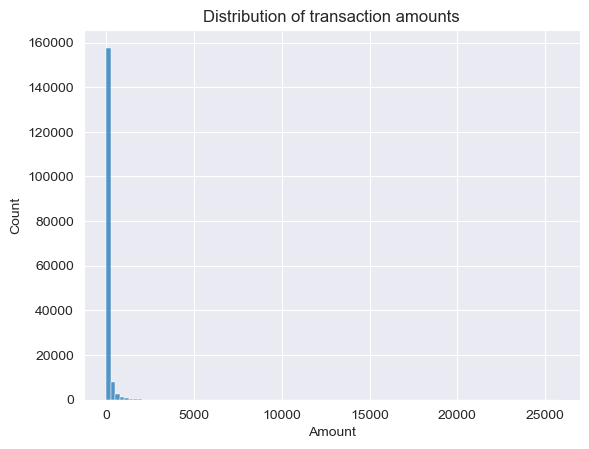

In [44]:
sns.histplot(data=raw_train, x='Amount', bins=100)
plt.title('Distribution of transaction amounts')
plt.show()

In [148]:
raw_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

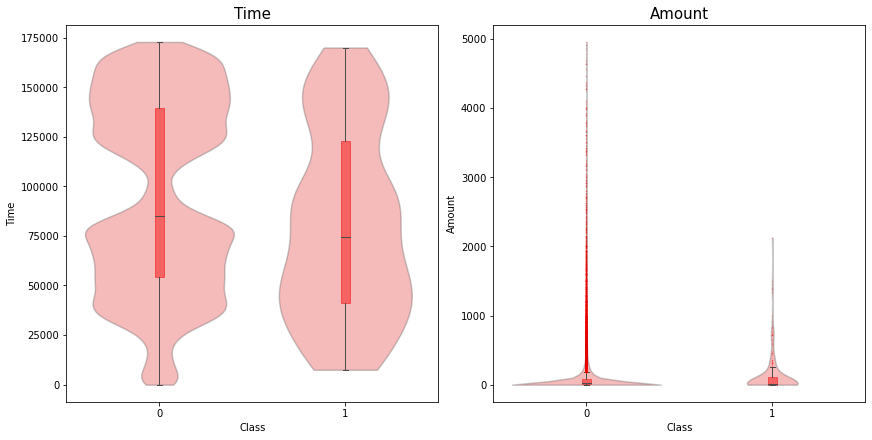

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), layout='constrained')
axes = axes.ravel()
cols = [0, -2]

for k, ax in enumerate(axes):
    p = sns.violinplot(data=raw_train, y=raw_train.columns[cols[k]], x='Class', ax=ax, color='red', cut=0, inner=None)
    boxprops = dict(color='r', alpha=0.5)
    flierprops = dict(marker='o', markeredgecolor='r', markersize=0.5, alpha=0.2)
    sns.boxplot(data = raw_train, y=raw_train.columns[cols[k]], x='Class', ax=ax, color='red', width=0.05, fliersize=0.5, linewidth=1, whis=1.5, boxprops=boxprops, flierprops=flierprops)

    p.axes.set_title(raw_train.columns[cols[k]],fontsize=15)
    p.tick_params(labelsize=10)
    plt.setp(ax.collections, alpha=.3)
    p

In [58]:
# Ratio of transactions under 100
len(raw_train[raw_train.Amount<100])/len(raw_train)

0.7978336181269166

In [61]:
# Maximum fraud amount
raw_train[raw_train.Class==1]['Amount'].max()

2125.87

# Outliers

In [41]:
def outliers_bounds(data, column_names):
    feat_outlier_counts = dict()
    for col in column_names:
        if data[col].dtype != object:
            q1 = np.quantile(data[col], 0.25)
            q3 = np.quantile(data[col], 0.75)
            iqr = q3 - q1
            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            above_df = data[data[col] > upper_bound]
            below_df = data[data[col] < lower_bound]

            above_count = len(above_df)
            below_count = len(below_df)
            total_count = above_count + below_count
            
            feat_outlier_counts[col] = [total_count]
    return pd.DataFrame(data=feat_outlier_counts.values(), index=feat_outlier_counts.keys(), columns=['Total count of outliers'])
#     return feat_outlier_counts
outliers_df = outliers_bounds(raw_train, raw_train.columns)
outliers_df

Total count of outliers
Time                          0
V1                         4256
V2                         8127
V3                         2021
V4                         6683
V5                         7359
V6                        13744
V7                         5306
V8                        14365
V9                         4959
V10                        5667
V11                         446
V12                        9140
V13                        1965
V14                        8555
V15                        1723
V16                        4868
V17                        4346
V18                        4599
V19                        6211
V20                       16797
V21                        8676
V22                         811
V23                       11124
V24                        2786
V25                        3276
V26                        3269
V27                       23570
V28                       18400
Amount                    19089
Class                       295

### Ratio of outliers in the features AND dataset with X% of outliers removed

In [443]:
def detect_outliers(data, limit, cols):
    outlier_percents = {}
    rows_to_remove = []
    for column in cols:
        if data[column].dtype != object:
            # quantiles
            q1 = np.quantile(data[column], 0.25)
            q3 = np.quantile(data[column], 0.75)
            # inter quantile range
            iqr = q3 - q1

            upper_bound = q3 + (1.5 * iqr)
            lower_bound = q1 - (1.5 * iqr)
            # all the outliers
            outliers = data[(data[column] > upper_bound) | (data[column] < lower_bound)][column]
            # select top limit%
            abs_sorted_outliers = abs(outliers).sort_values()
            threshold = abs_sorted_outliers.quantile(1-limit)
            top_percent = abs_sorted_outliers[abs_sorted_outliers >= threshold]
            top_percent_index = top_percent.index
            [rows_to_remove.append(n) for n in top_percent_index]
            
            outlier_percentage = len(outliers) / len(data[column]) * 100
            outlier_percents[column] = outlier_percentage
            outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])

    return outlier_dataframe.sort_values(by = 'Outlier_percentage', ascending = False), set(rows_to_remove)


indexes_to_remove = detect_outliers(raw_train, 0.1, ['V17', 'V14', 'V12', 'V10'])[1]
detect_outliers(raw_train, 0.1, raw_train.columns)[0]

Outlier_percentage
V27              13.792982
Amount           11.170736
V28              10.767538
V20               9.829475
V8                8.406287
V6                8.042883
V23               6.509679
V12               5.348658
V21               5.077128
V14               5.006320
V2                4.755858
V5                4.306430
V4                3.910840
V19               3.634629
V10               3.316285
V7                3.105030
V9                2.901969
V16               2.848716
V18               2.691299
V17               2.543246
V1                2.490578
V25               1.917090
V26               1.912994
V24               1.630346
V3                1.182674
V13               1.149903
V15               1.008286
V22               0.474591
V11               0.260996
Class             0.172632
Time              0.000000

In [446]:
# indexes_to_remove
print(f'raw_train original length: {len(raw_train)}')
print(f'indexes_to_remove original length: {len(indexes_to_remove)}')
print(f'difference of original-remove: {len(raw_train)-len(indexes_to_remove)}')
print(f'length of dataset after removal: {len(raw_train.drop(index=indexes_to_remove))}')
raw_train_minus_outliers = raw_train.drop(index=indexes_to_remove)
print(f'length of dataset with removed outliers: {len(raw_train_minus_outliers)}')

raw_train original length: 170884
indexes_to_remove original length: 1990
difference of original-remove: 168894
length of dataset after removal: 168894
length of dataset with removed outliers: 168894


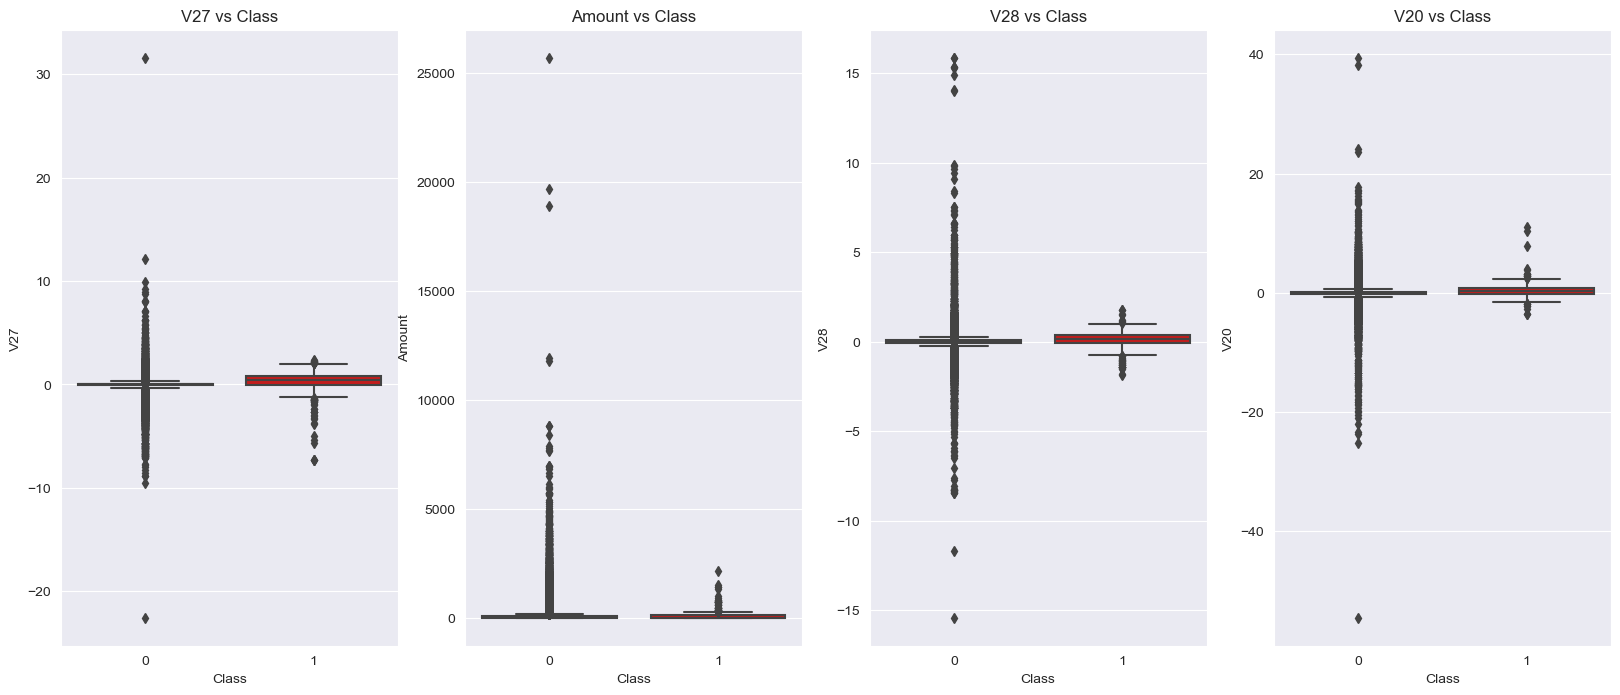

In [440]:
f, axes = plt.subplots(ncols=4, figsize=(20,8))
colors = ["#0101DF", "#DF0101"]

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V27", data=raw_train, palette=colors, ax=axes[0])
axes[0].set_title('V27 vs Class')

sns.boxplot(x="Class", y="Amount", data=raw_train, palette=colors, ax=axes[1])
axes[1].set_title('Amount vs Class')


sns.boxplot(x="Class", y="V28", data=raw_train, palette=colors, ax=axes[2])
axes[2].set_title('V28 vs Class')


sns.boxplot(x="Class", y="V20", data=raw_train, palette=colors, ax=axes[3])
axes[3].set_title('V20 vs Class')

plt.show()

In [293]:
raw_train_under_5000 = raw_train[raw_train['Amount'] <= 5000]

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- Almost 80% of all transactions are under 100
- The maximum fraud amount is 2125.87
- 11.71% of the Amount are outliers
- The features (except Time, Amount and Class) seem to be standardised, as their location is around 0.
- Most of the featres distribution vaguely resemble normal distribution, but with very high curtosis

- **Based on the information from the AML dep all transactions above 5 000 will be checked by default. Our model should focus on transactions below this amount. -> We remove all together 34 transactions (there are no fraudulent transactions among them)**
- Outliers of other features will not be removed as it is difficuled to assessed how much information will be lost.

Text(0.5, 1.0, 'Amount vs Class')

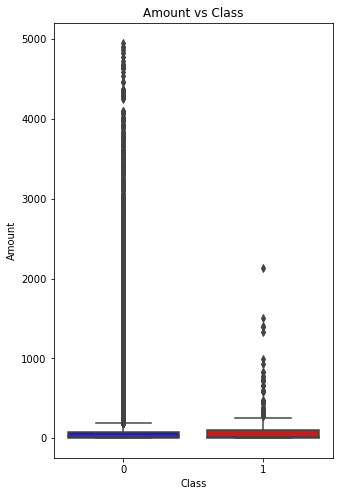

In [67]:
fig, ax = plt.subplots(figsize=(5, 8))
sns.boxplot(x="Class", y="Amount", data=raw_train, palette=colors, ax=ax)
ax.set_title("Amount vs Class")


# 4.5. Spearman correlation between features

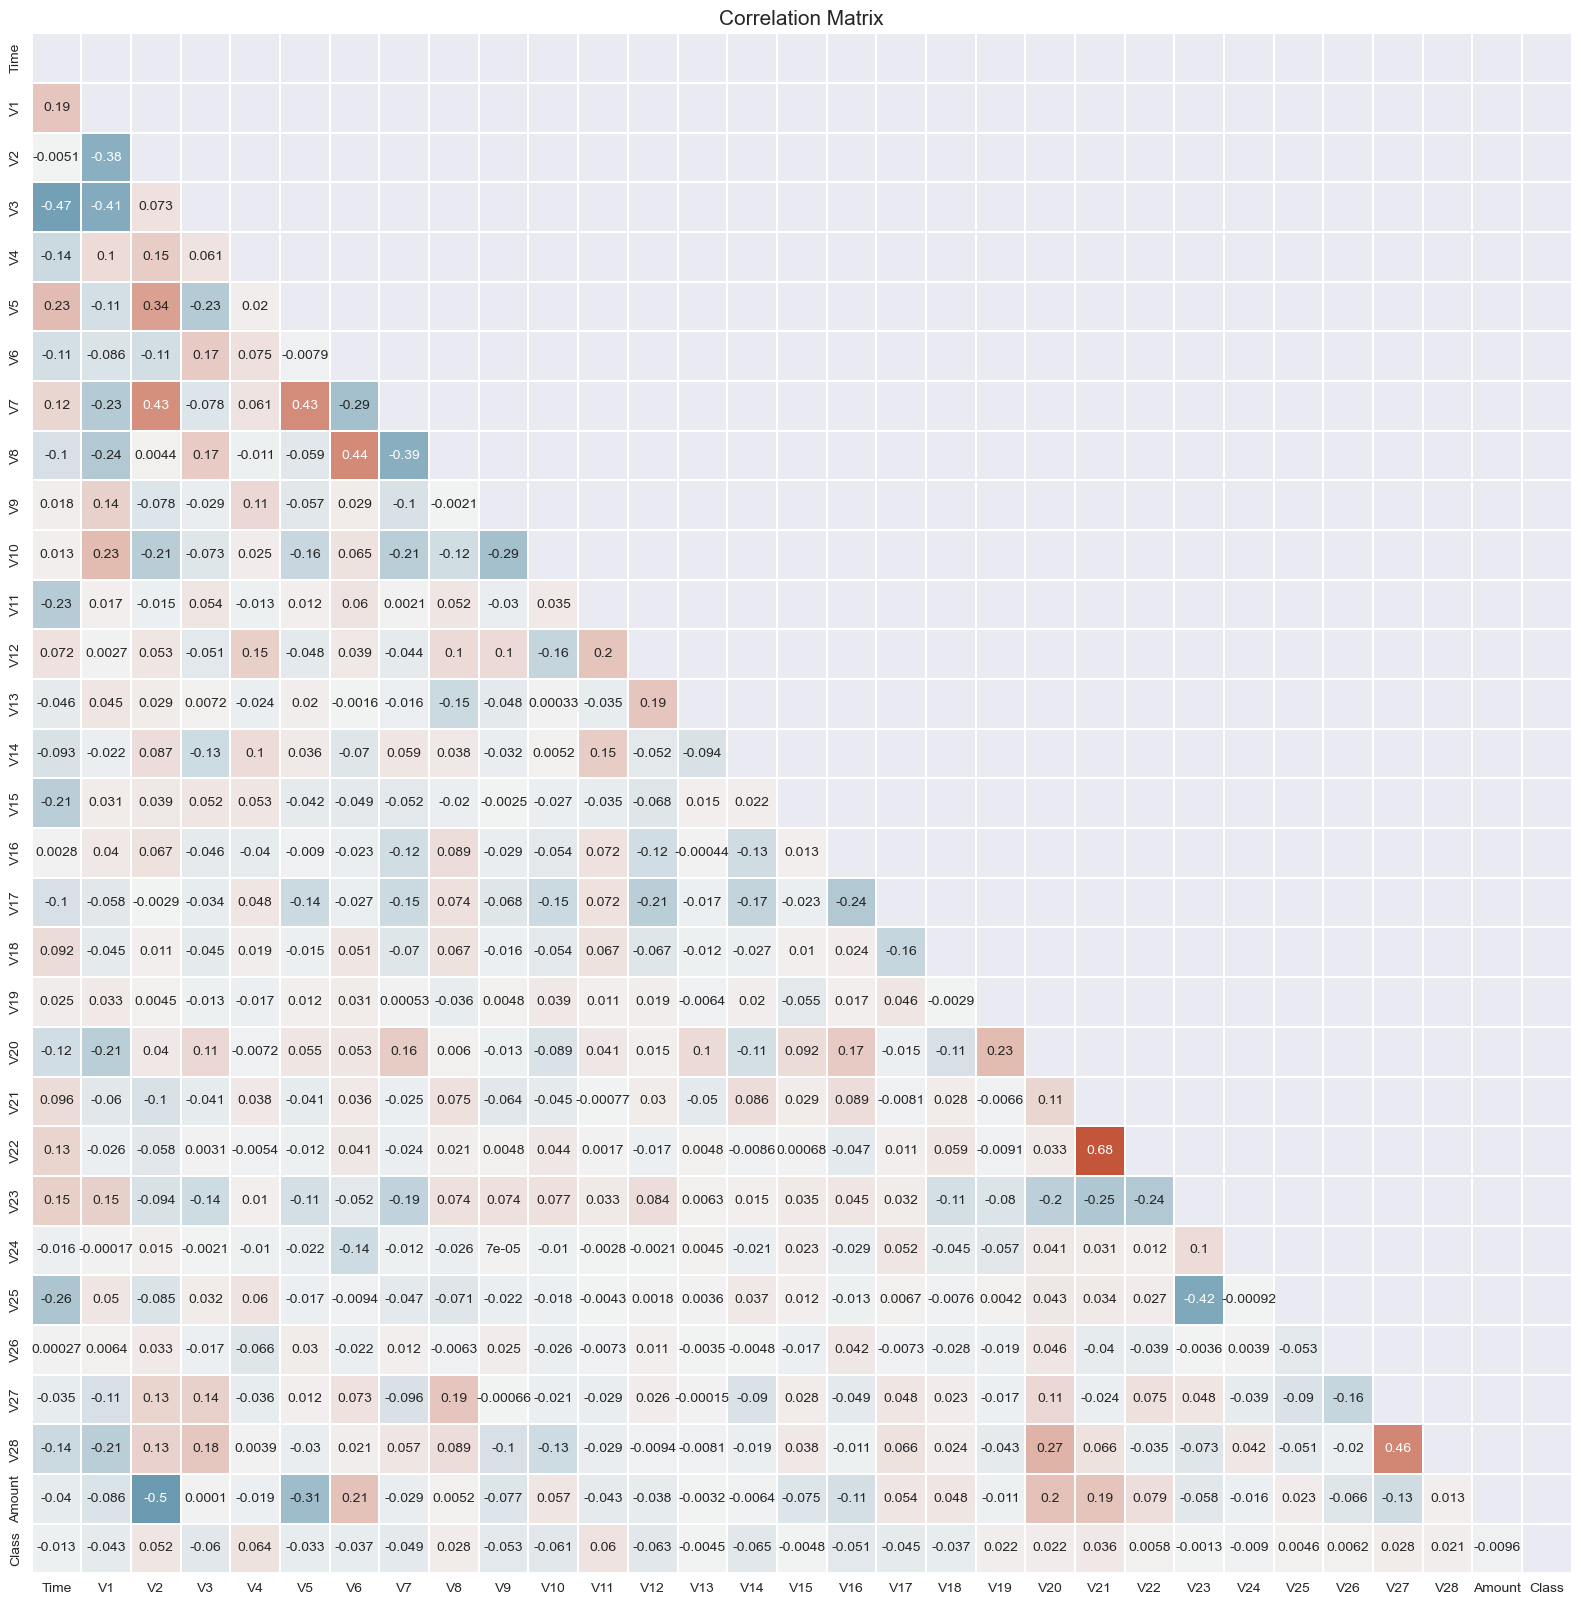

In [162]:
features = [
    'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
    'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
    'Class'
]

correlation_matrix = raw_train[features].corr(method="spearman") # pearson / spearman

#from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Correlation Matrix", fontsize=15)

Note:
The Spearman correlation between two variables is equal to the Pearson correlation between the rank values of those two variables; while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships (whether linear or not). If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

### Highlighting the correlations below -0.1 and above 0.1

<AxesSubplot: >

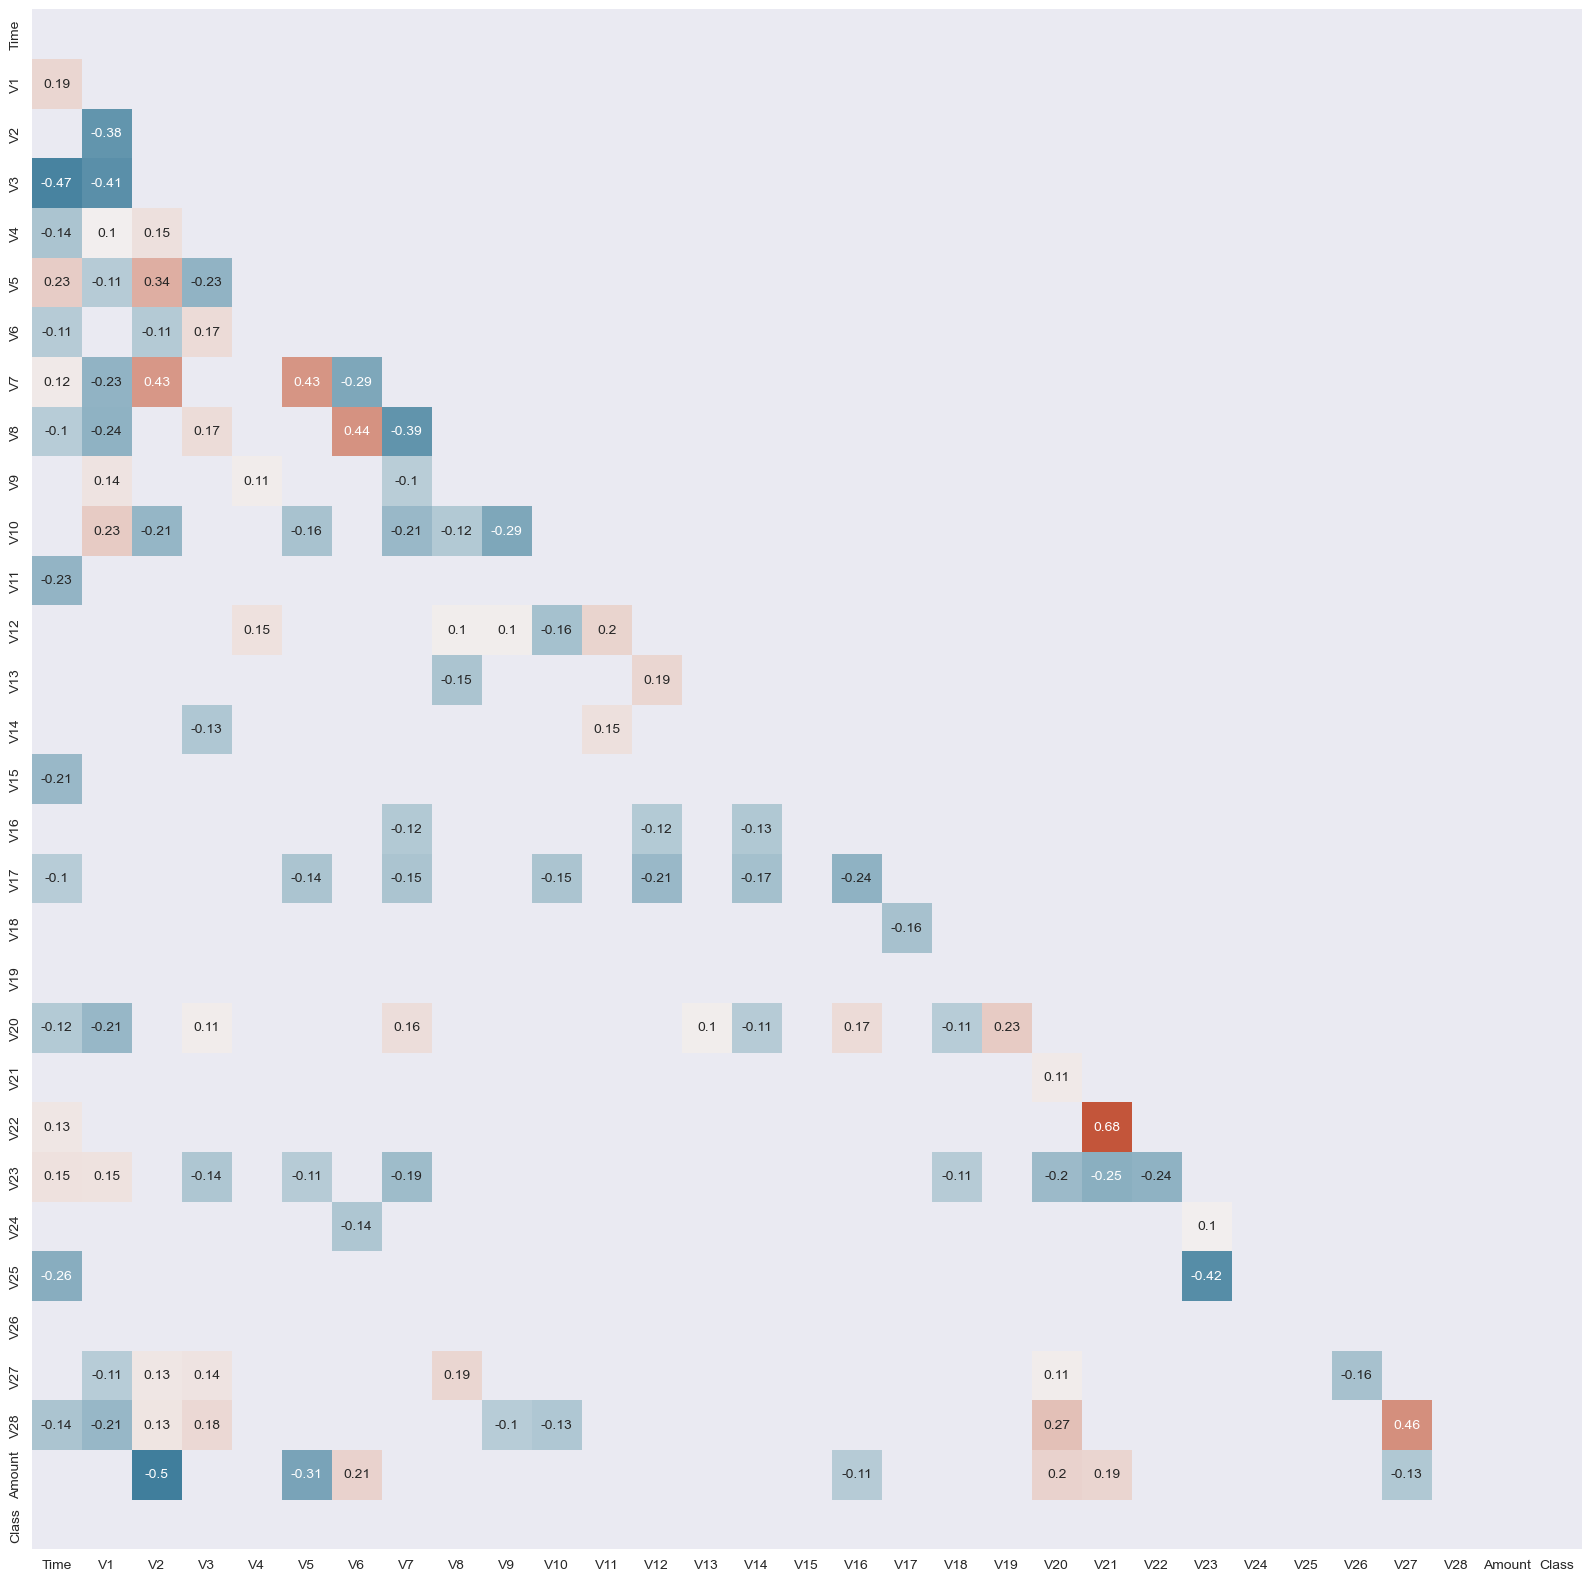

In [165]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(
    correlation_matrix[(correlation_matrix<-0.1)|(correlation_matrix>0.1)], 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool, )), 
    annot=True,
    cbar=False,
    cmap=sns.diverging_palette(230, 20, as_cmap=True)
)

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- 

# Dataset testing: Time scaled → MinMax, Amount scaled → Robust

In [55]:
imputer = SimpleImputer(strategy='most_frequent')
amount_scaler = RobustScaler()
time_scaler = MinMaxScaler(feature_range=(0,1))

In [56]:
clean_train = DataCleaner(hour=False, feature_to_drop=[], labels=True, imputer=imputer, \
                          amount_scaler=amount_scaler, time_scaler=time_scaler)

In [57]:
X_train_time_amt_robust, y_train = clean_train.fit_transform(raw_train)

In [58]:
X_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [59]:
X_val_time_amt_robust, y_val = clean_train.transform(raw_val)

# Dataset testing: Hours, Amount scaled → Robust

In [70]:
imputer = SimpleImputer(strategy='most_frequent')
amount_scaler = RobustScaler()

In [71]:
clean_train_hour = DataCleaner(hour=True, feature_to_drop=[], labels=True, imputer=imputer, \
                          amount_scaler=amount_scaler, time_scaler=None)

In [72]:
X_train_hour_amt_robust, y_train = clean_train_hour.fit_transform(raw_train)

In [73]:
X_train_hour_amt_robust.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'hour_24'],
      dtype='object')

In [128]:
X_val_hour_amt_robust, y_val = clean_train_hour.transform(raw_val)

# Dataset testing: Hours, Amount scaled → Robust, Log

In [8]:
imputer = SimpleImputer(strategy='most_frequent')
amount_scaler = RobustScaler()

In [9]:
clean_train_hour_log = DataCleaner(hour=True, feature_to_drop=[], labels=True, imputer=imputer, \
                          amount_scaler=amount_scaler, time_scaler=None, amount_log=True)

In [10]:
X_train_hour_amt_robust_log, y_train = clean_train_hour_log.fit_transform(raw_train)

In [12]:
X_train_hour_amt_robust_log.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'hour_24'],
      dtype='object')

In [13]:
X_val_hour_amt_robust_log, y_val = clean_train_hour_log.transform(raw_val)

# Testing the datasets

In [14]:
from IPython.display import display
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score

from sklearn.ensemble import RandomForestClassifier #proba #featimp
from imblearn.ensemble import BalancedRandomForestClassifier #proba #featimp
from sklearn.linear_model import LogisticRegression #proba #coef
from sklearn.svm import SVC #kernel #proba #coef 
from sklearn.neighbors import KNeighborsClassifier #proba
from sklearn.naive_bayes import GaussianNB #proba
from sklearn.ensemble import AdaBoostClassifier #proba #featimp
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis #proba
from sklearn.neural_network import MLPClassifier #coef #proba
import xgboost as xgb #featimp #coef #proba

In [15]:
rf_clf = RandomForestClassifier() #proba #featimp
brf_clf = BalancedRandomForestClassifier() #proba #featimp
lr_clf = LogisticRegression() #proba #coef
svc_rbf_clf = SVC(kernel='rbf', probability=True) #kernel #proba #coef 
svc_ploy_clf = SVC(kernel='poly', probability=True)
knn_clf = KNeighborsClassifier() #proba
gnb_clf = GaussianNB() #proba
ada_clf = AdaBoostClassifier() #proba #featimp
qda_clf = QuadraticDiscriminantAnalysis() #proba
mlp_clf = MLPClassifier() #coef #proba
xgb_clf = xgb.XGBClassifier() #featimp #coef #proba
xgbrf_clf = xgb.XGBRFClassifier() #featimp #coef #proba

In [16]:
def model_tester(clf, clf_name, X_train, y_train, X_val, y_val):
    print(f'============ {clf_name} ============')
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    try:
        feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_})
        print(feature_importances.sort_values('importance', ascending=False, inplace=True))
    except Exception as e: 
        print(e)
        print(f'The {clf_name} model does not have a feature importance parameter')
        
    try:
        coefs = pd.DataFrame({'feature': X_train.columns, 'coef': clf.coef_})
        print(coefs.sort_values('coef', ascending=False, inplace=True))
    except Exception as e: 
        print(e)
        print(f'The {clf_name} model does not have a coef parameter')
    
    start_time = time.time()
    y_pred = clf.predict(X_val)
    test_time = time.time() - start_time
    
    print(metrics.classification_report(y_val, y_pred, digits=4), end='\n\n===============================================\n')
    bal_acc_score = balanced_accuracy_score(y_val, y_pred)
#     print(bal_acc_score, end='\n\n===============================================\n')
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    y_prob = clf.predict_proba(X_val)[:,1]
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    plot_roc_curve(fpr,tpr)
    plt.show()
    rocauc_score = roc_auc_score(y_val, y_prob)
    print(f'ROC AUC score: {rocauc_score}', end='\n\n===============================================\n')
    conf_mtr = confusion_matrix(y_val, y_pred)
    print(conf_mtr, end='\n\n===============================================\n')
    return [bal_acc_score,precisions[1], recalls[1], f1, conf_mtr[0,1], conf_mtr[1,0], train_time, test_time]

In [17]:
model_names = ['rf_clf', 'brf_clf', 'lr_clf', 'svc_rbf_clf', 'svc_ploy_clf', 'knn_clf', 'gnb_clf', 'ada_clf',\
               'qda_clf', 'mlp_clf', 'xgb_clf', 'xgbrf_clf']
models = [rf_clf, brf_clf, lr_clf, svc_rbf_clf, svc_ploy_clf, knn_clf, gnb_clf, ada_clf, qda_clf, mlp_clf, xgb_clf, xgbrf_clf]

# Time scaled → MinMax, Amount scaled → Robust

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9351    0.7347    0.8229        98

    accuracy                         0.9995     56961
   macro avg     0.9673    0.8673    0.9113     56961
weighted avg     0.9994    0.9995    0.9994     56961




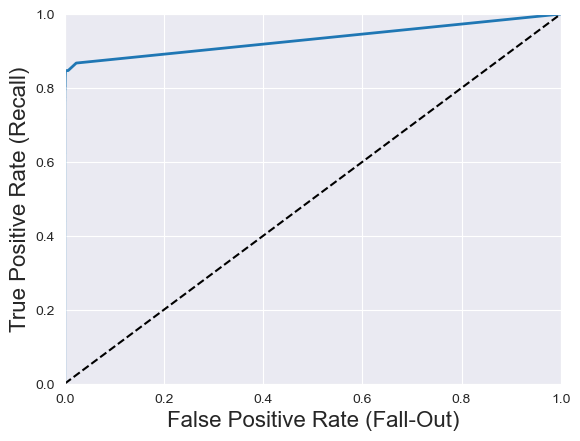

ROC AUC score: 0.9317555944524021

[[56858     5]
 [   26    72]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9785    0.9890     56863
           1     0.0642    0.8571    0.1194        98

    accuracy                         0.9782     56961
   macro avg     0.5320    0.9178    0.5542     56961
weighted avg     0.9981    0.9782    0.9875     56961




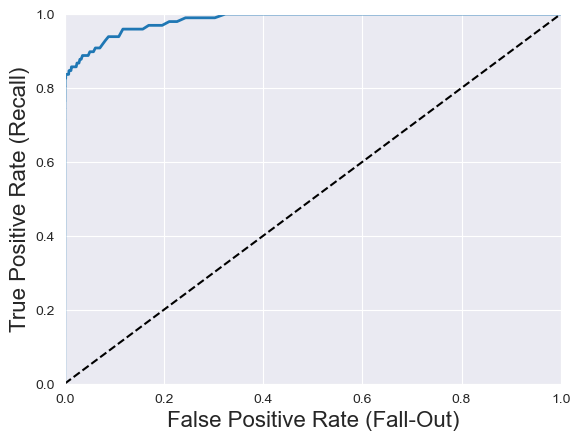

ROC AUC score: 0.983534090350348

[[55638  1225]
 [   14    84]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8312    0.6531    0.7314        98

    accuracy                         0.9992     56961
   macro avg     0.9153    0.8264    0.8655     56961
weighted avg     0.9991    0.9992    0.9991     56961




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


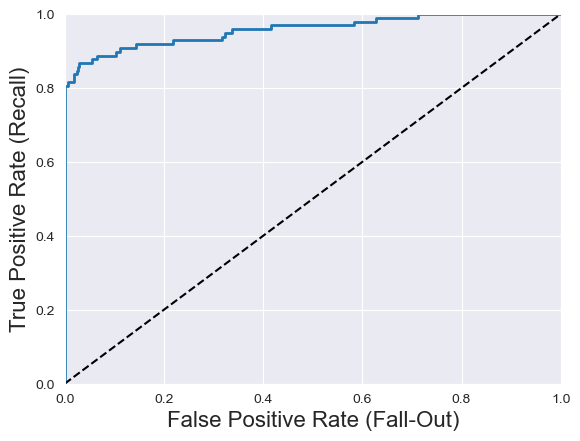

ROC AUC score: 0.9575933850317646

[[56850    13]
 [   34    64]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56863
           1     0.9275    0.6531    0.7665        98

    accuracy                         0.9993     56961
   macro avg     0.9635    0.8265    0.8831     56961
weighted avg     0.9993    0.9993    0.9993     56961




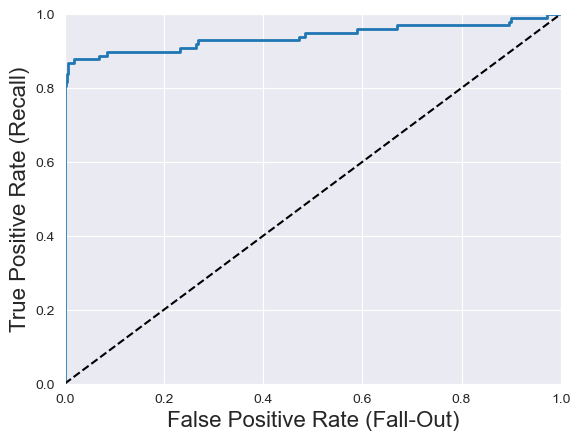

ROC AUC score: 0.939208344294755

[[56858     5]
 [   34    64]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9997     56863
           1     0.8861    0.7143    0.7910        98

    accuracy                         0.9994     56961
   macro avg     0.9428    0.8571    0.8953     56961
weighted avg     0.9993    0.9994    0.9993     56961




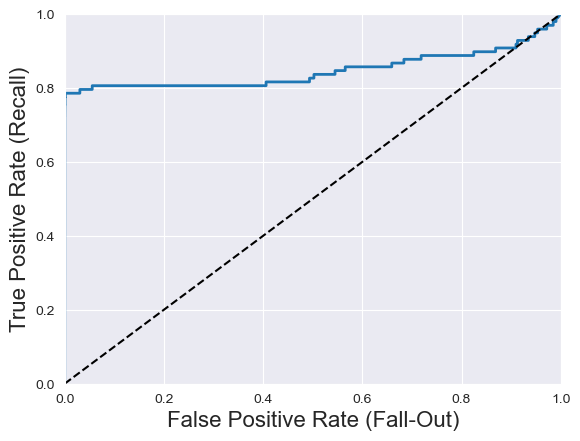

ROC AUC score: 0.8473501652916587

[[56854     9]
 [   28    70]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9996     56863
           1     0.8919    0.6735    0.7674        98

    accuracy                         0.9993     56961
   macro avg     0.9457    0.8367    0.8835     56961
weighted avg     0.9993    0.9993    0.9992     56961




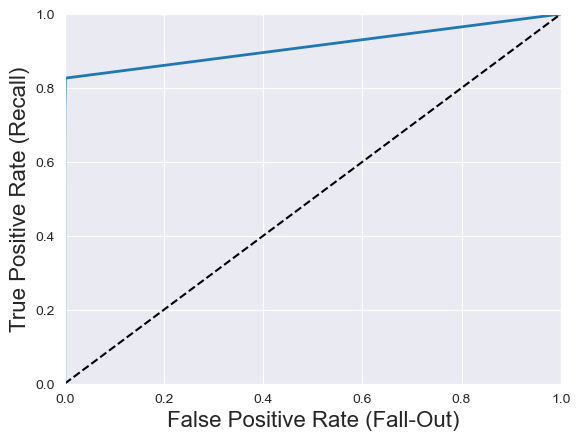

ROC AUC score: 0.9130749093686328

[[56855     8]
 [   32    66]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9778    0.9886     56863
           1     0.0590    0.8061    0.1100        98

    accuracy                         0.9775     56961
   macro avg     0.5293    0.8920    0.5493     56961
weighted avg     0.9980    0.9775    0.9871     56961




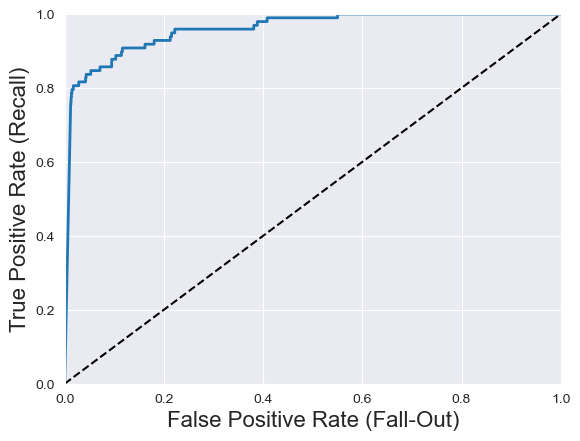

ROC AUC score: 0.9592930484189173

[[55603  1260]
 [   19    79]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9993    0.9997    0.9995     56863
           1     0.7895    0.6122    0.6897        98

    accuracy                         0.9991     56961
   macro avg     0.8944    0.8060    0.8446     56961
weighted avg     0.9990    0.9991    0.9990     56961




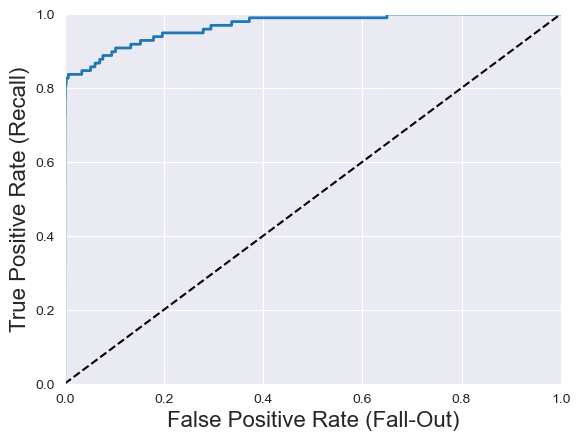

ROC AUC score: 0.9682215076910599

[[56847    16]
 [   38    60]]

============ qda_clf ============
'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9774    0.9884     56863
           1     0.0593    0.8265    0.1107        98

    accuracy                         0.9772     56961
   macro avg     0.5295    0.9020    0.5496     56961
weighted avg     0.9981    0.9772    0.9869     56961




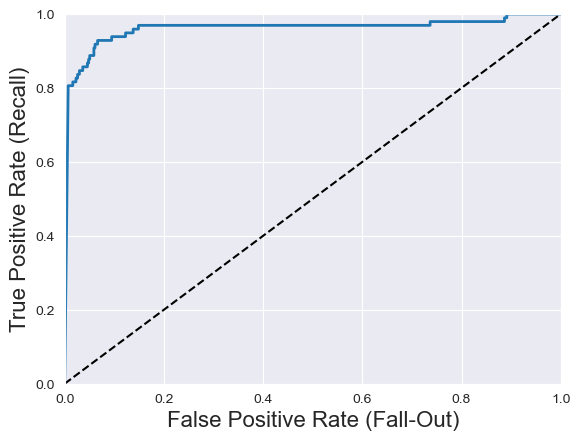

ROC AUC score: 0.9611954906296445

[[55579  1284]
 [   17    81]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9000    0.7347    0.8090        98

    accuracy                         0.9994     56961
   macro avg     0.9498    0.8673    0.9043     56961
weighted avg     0.9994    0.9994    0.9994     56961




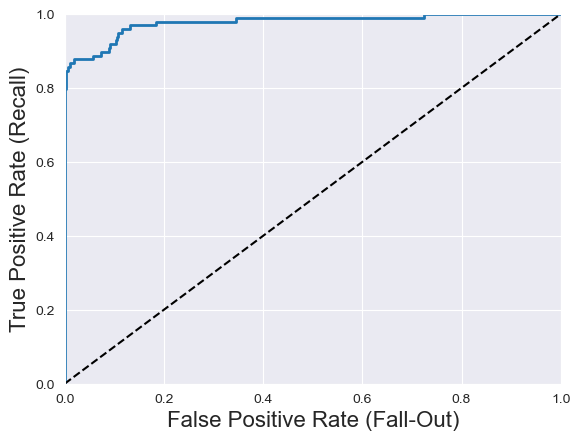

ROC AUC score: 0.9777698779773942

[[56855     8]
 [   26    72]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56863
           1     0.9481    0.7449    0.8343        98

    accuracy                         0.9995     56961
   macro avg     0.9738    0.8724    0.9170     56961
weighted avg     0.9995    0.9995    0.9995     56961




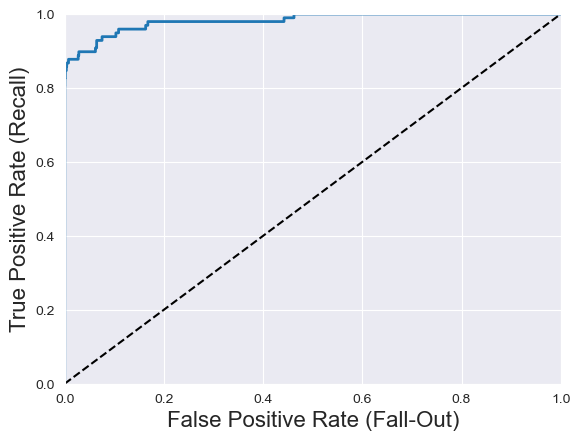

ROC AUC score: 0.9817556482874881

[[56859     4]
 [   25    73]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8636    0.7755    0.8172        98

    accuracy                         0.9994     56961
   macro avg     0.9316    0.8876    0.9085     56961
weighted avg     0.9994    0.9994    0.9994     56961




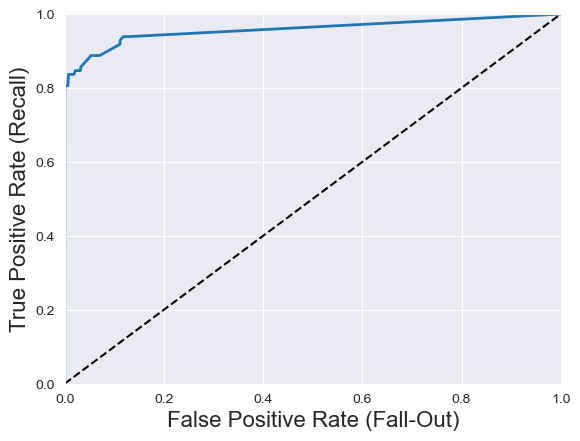

ROC AUC score: 0.9582779878741854

[[56851    12]
 [   22    76]]



In [89]:
eval_dict_time = dict()

for i, m in enumerate(models):
    eval_dict[model_names[i]] = model_tester(m, model_names[i], X_train=X_train_time_amt_robust, y_train=y_train,\
                                             X_val=X_val_time_amt_robust, y_val=y_val)

In [99]:
eval_df_time = pd.DataFrame(data=eval_dict.values(), index=eval_dict.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [133]:
eval_df_time#_time

bal_acc_score  \
rf_clf             0.867303   
brf_clf            0.917800   
lr_clf             0.826416   
svc_rbf_clf        0.826487   
svc_ploy_clf       0.857064   
knn_clf            0.836664   
gnb_clf            0.891982   
ada_clf            0.805982   
qda_clf            0.901975   
mlp_clf            0.867277   
xgb_clf            0.872414   
xgbrf_clf          0.887650   

                                                     precisions  \
rf_clf          [0.0017204754130018785, 0.935064935064935, 1.0]   
brf_clf       [0.0017204754130018785, 0.06417112299465241, 1.0]   
lr_clf         [0.0017204754130018785, 0.8311688311688312, 1.0]   
svc_rbf_clf     [0.0017204754130018785, 0.927536231884058, 1.0]   
svc_ploy_clf   [0.0017204754130018785, 0.8860759493670886, 1.0]   
knn_clf        [0.0017204754130018785, 0.8918918918918919, 1.0]   
gnb_clf       [0.0017204754130018785, 0.05899925317401045, 1.0]   
ada_clf        [0.0017204754130018785, 0.7894736842105263, 1.0]   
qda_clf       [0.0017204754130018785, 0.05934065934065934, 1.0]   
mlp_clf                       [0.0017204754130018785, 0.9, 1.0]   
xgb_clf         [0.0017204754130018785, 0.948051948051948, 1.0]   
xgbrf_clf      [0.0017204754130018785, 0.8636363636363636, 1.0]   

                                     recalls        f1  false_positives  \
rf_clf        [1.0, 0.7346938775510204, 0.0]  0.822857                5   
brf_clf       [1.0, 0.8571428571428571, 0.0]  0.119403             1225   
lr_clf        [1.0, 0.6530612244897959, 0.0]  0.731429               13   
svc_rbf_clf   [1.0, 0.6530612244897959, 0.0]  0.766467                5   
svc_ploy_clf  [1.0, 0.7142857142857143, 0.0]  0.790960                9   
knn_clf        [1.0, 0.673469387755102, 0.0]  0.767442                8   
gnb_clf       [1.0, 0.8061224489795918, 0.0]  0.109951             1260   
ada_clf       [1.0, 0.6122448979591837, 0.0]  0.689655               16   
qda_clf        [1.0, 0.826530612244898, 0.0]  0.110731             1284   
mlp_clf       [1.0, 0.7346938775510204, 0.0]  0.808989                8   
xgb_clf       [1.0, 0.7448979591836735, 0.0]  0.834286                4   
xgbrf_clf     [1.0, 0.7755102040816326, 0.0]  0.817204               12   

              false_negatives  train_time  test_time  
rf_clf                     26  132.528531   0.371084  
brf_clf                    14    2.925664   0.276063  
lr_clf                     34    0.993161   0.003002  
svc_rbf_clf                34  743.895300   8.758026  
svc_ploy_clf               28   82.850833   0.585133  
knn_clf                    32    0.024006   6.845876  
gnb_clf                    19    0.082021   0.025010  
ada_clf                    38   44.457026   0.383087  
qda_clf                    17    0.206302   0.037009  
mlp_clf                    26   19.317642   0.036007  
xgb_clf                    25    8.327997   0.024006  
xgbrf_clf                  22    9.628688   0.022005

# Hours, Amount scaled → Robust

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56863
           1     0.9359    0.7449    0.8295        98

    accuracy                         0.9995     56961
   macro avg     0.9677    0.8724    0.9146     56961
weighted avg     0.9995    0.9995    0.9994     56961




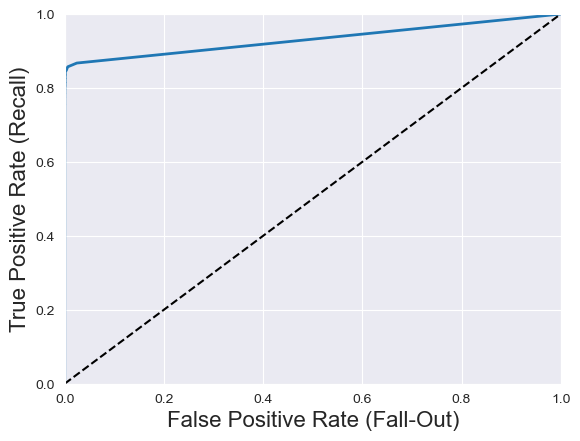

ROC AUC score: 0.9317909461588127

[[56858     5]
 [   25    73]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9828    0.9912     56863
           1     0.0784    0.8469    0.1435        98

    accuracy                         0.9826     56961
   macro avg     0.5391    0.9149    0.5673     56961
weighted avg     0.9981    0.9826    0.9898     56961




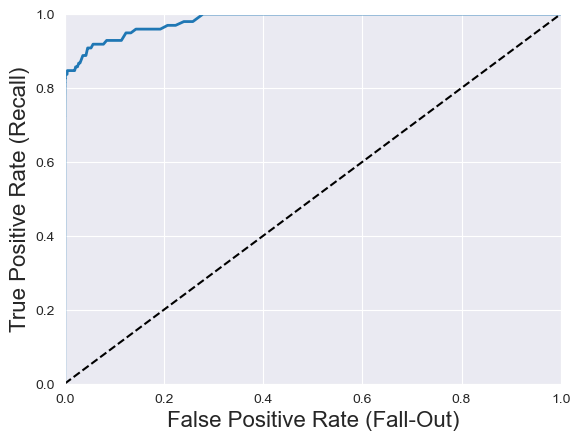

ROC AUC score: 0.9825821963064107

[[55887   976]
 [   15    83]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8182    0.6429    0.7200        98

    accuracy                         0.9991     56961
   macro avg     0.9088    0.8213    0.8598     56961
weighted avg     0.9991    0.9991    0.9991     56961




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


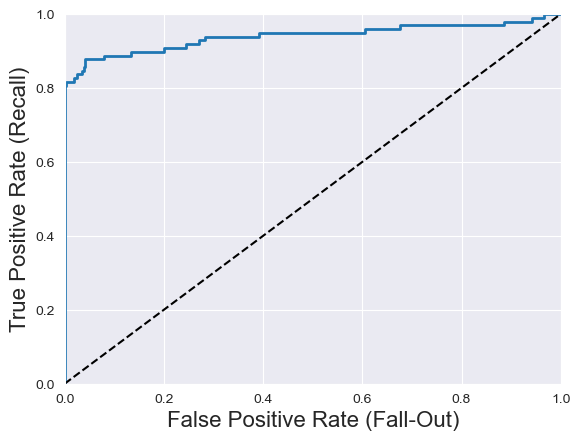

ROC AUC score: 0.9398798472662724

[[56849    14]
 [   35    63]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56863
           1     0.9275    0.6531    0.7665        98

    accuracy                         0.9993     56961
   macro avg     0.9635    0.8265    0.8831     56961
weighted avg     0.9993    0.9993    0.9993     56961




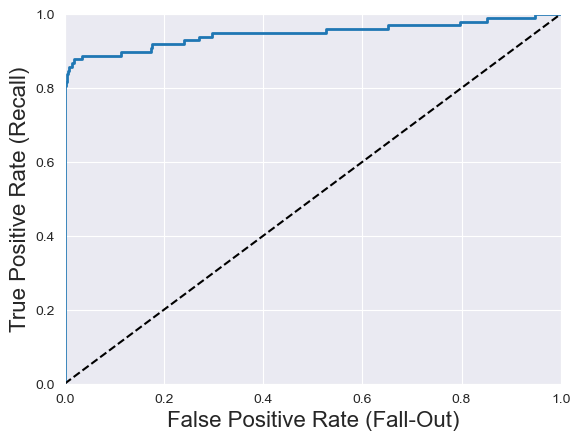

ROC AUC score: 0.9475163542018464

[[56858     5]
 [   34    64]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9324    0.7041    0.8023        98

    accuracy                         0.9994     56961
   macro avg     0.9660    0.8520    0.9010     56961
weighted avg     0.9994    0.9994    0.9994     56961




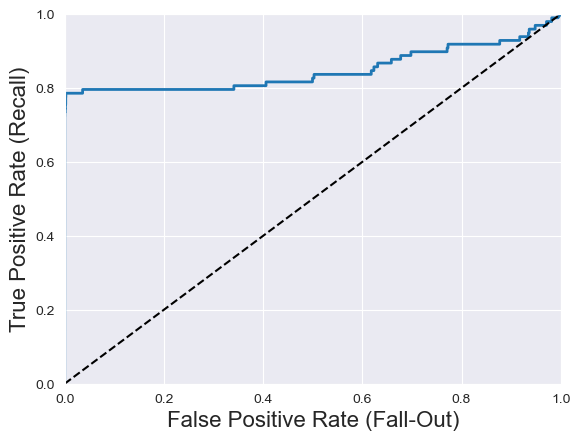

ROC AUC score: 0.8488998979645672

[[56858     5]
 [   29    69]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9996     56863
           1     0.8919    0.6735    0.7674        98

    accuracy                         0.9993     56961
   macro avg     0.9457    0.8367    0.8835     56961
weighted avg     0.9993    0.9993    0.9992     56961




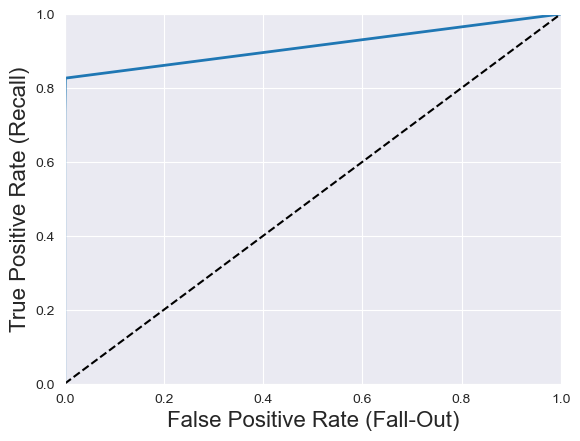

ROC AUC score: 0.9130666546554608

[[56855     8]
 [   32    66]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9587    0.9788     56863
           1     0.0326    0.8061    0.0626        98

    accuracy                         0.9585     56961
   macro avg     0.5161    0.8824    0.5207     56961
weighted avg     0.9980    0.9585    0.9772     56961




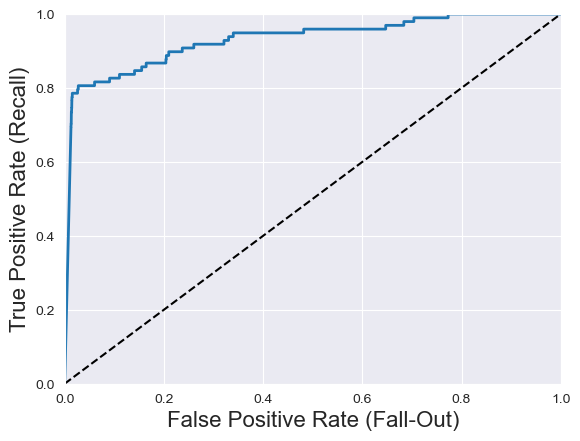

ROC AUC score: 0.931490636104608

[[54517  2346]
 [   19    79]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995     56863
           1     0.7750    0.6327    0.6966        98

    accuracy                         0.9991     56961
   macro avg     0.8872    0.8162    0.8481     56961
weighted avg     0.9990    0.9991    0.9990     56961




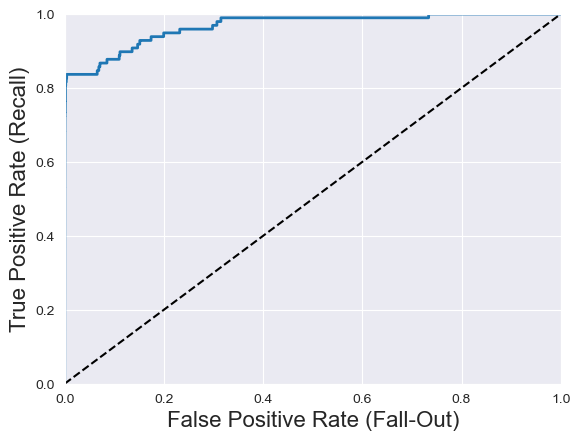

ROC AUC score: 0.967029598889131

[[56845    18]
 [   36    62]]

============ qda_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9696    0.9844     56863
           1     0.0442    0.8163    0.0839        98

    accuracy                         0.9693     56961
   macro avg     0.5220    0.8930    0.5342     56961
weighted avg     0.9980    0.9693    0.9829     56961




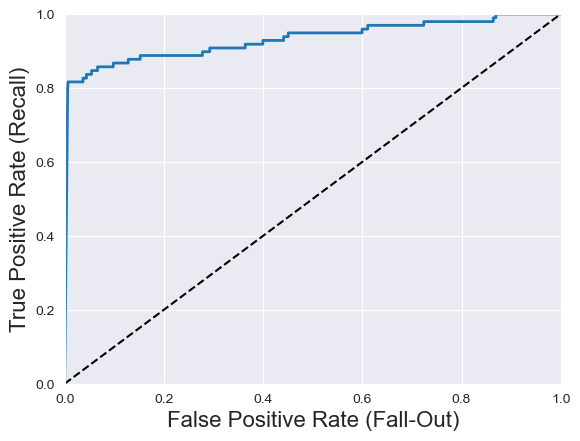

ROC AUC score: 0.9315736318620444

[[55135  1728]
 [   18    80]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8974    0.7143    0.7955        98

    accuracy                         0.9994     56961
   macro avg     0.9485    0.8571    0.8976     56961
weighted avg     0.9993    0.9994    0.9993     56961




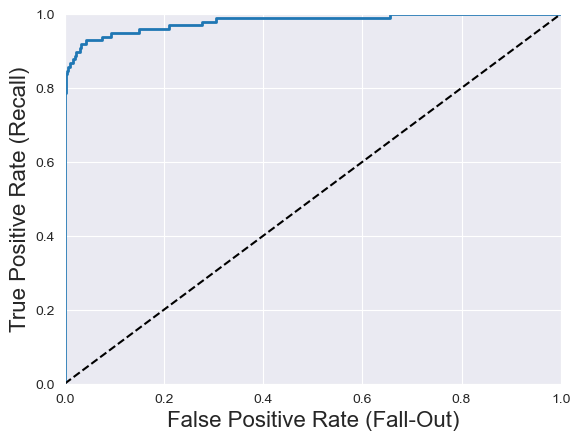

ROC AUC score: 0.9799521729096824

[[56855     8]
 [   28    70]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56863
           1     0.9375    0.7653    0.8427        98

    accuracy                         0.9995     56961
   macro avg     0.9685    0.8826    0.9212     56961
weighted avg     0.9995    0.9995    0.9995     56961




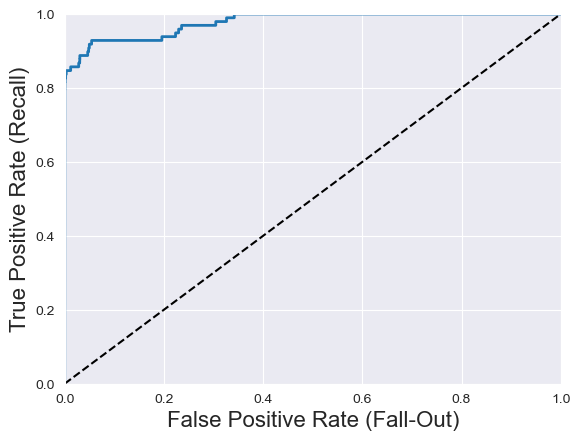

ROC AUC score: 0.9779187319899207

[[56858     5]
 [   23    75]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8750    0.7857    0.8280        98

    accuracy                         0.9994     56961
   macro avg     0.9373    0.8928    0.9138     56961
weighted avg     0.9994    0.9994    0.9994     56961




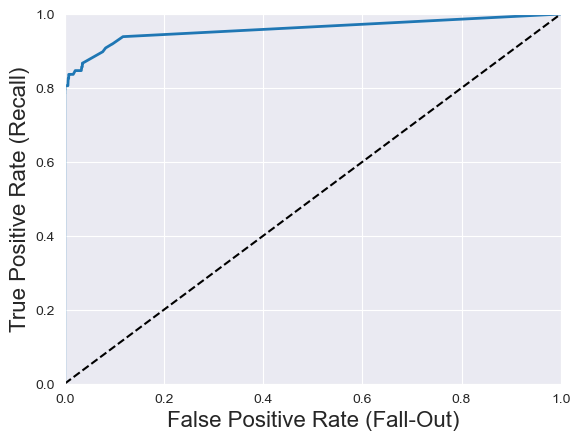

ROC AUC score: 0.9590715170404198

[[56852    11]
 [   21    77]]



In [94]:
eval_dict_hours = dict()

for i, m in enumerate(models):
    eval_dict_hours[model_names[i]] = model_tester(m, model_names[i], X_train=X_train_hour_amt_robust, y_train=y_train,\
                                             X_val=X_val_hour_amt_robust, y_val=y_val)

In [95]:
eval_df_hour = pd.DataFrame(data=eval_dict_hours.values(), index=eval_dict_hours.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [96]:
eval_df_hour

bal_acc_score  \
rf_clf             0.872405   
brf_clf            0.914887   
lr_clf             0.821305   
svc_rbf_clf        0.826487   
svc_ploy_clf       0.851997   
knn_clf            0.836664   
gnb_clf            0.882433   
ada_clf            0.816168   
qda_clf            0.892969   
mlp_clf            0.857073   
xgb_clf            0.882609   
xgbrf_clf          0.892760   

                                                     precisions  \
rf_clf         [0.0017204754130018785, 0.9358974358974359, 1.0]   
brf_clf       [0.0017204754130018785, 0.07837582625118036, 1.0]   
lr_clf         [0.0017204754130018785, 0.8181818181818182, 1.0]   
svc_rbf_clf     [0.0017204754130018785, 0.927536231884058, 1.0]   
svc_ploy_clf   [0.0017204754130018785, 0.9324324324324325, 1.0]   
knn_clf        [0.0017204754130018785, 0.8918918918918919, 1.0]   
gnb_clf       [0.0017204754130018785, 0.03257731958762886, 1.0]   
ada_clf                     [0.0017204754130018785, 0.775, 1.0]   
qda_clf       [0.0017204754130018785, 0.04424778761061947, 1.0]   
mlp_clf        [0.0017204754130018785, 0.8974358974358975, 1.0]   
xgb_clf                    [0.0017204754130018785, 0.9375, 1.0]   
xgbrf_clf                   [0.0017204754130018785, 0.875, 1.0]   

                                     recalls        f1  false_positives  \
rf_clf        [1.0, 0.7448979591836735, 0.0]  0.829545                5   
brf_clf       [1.0, 0.8469387755102041, 0.0]  0.143475              976   
lr_clf        [1.0, 0.6428571428571429, 0.0]  0.720000               14   
svc_rbf_clf   [1.0, 0.6530612244897959, 0.0]  0.766467                5   
svc_ploy_clf  [1.0, 0.7040816326530612, 0.0]  0.802326                5   
knn_clf        [1.0, 0.673469387755102, 0.0]  0.767442                8   
gnb_clf       [1.0, 0.8061224489795918, 0.0]  0.062624             2346   
ada_clf       [1.0, 0.6326530612244898, 0.0]  0.696629               18   
qda_clf       [1.0, 0.8163265306122449, 0.0]  0.083945             1728   
mlp_clf       [1.0, 0.7142857142857143, 0.0]  0.795455                8   
xgb_clf       [1.0, 0.7653061224489796, 0.0]  0.842697                5   
xgbrf_clf     [1.0, 0.7857142857142857, 0.0]  0.827957               11   

              false_negatives  train_time  test_time  
rf_clf                     25  106.481109   0.394089  
brf_clf                    15    2.935665   0.298614  
lr_clf                     35    1.528347   0.012003  
svc_rbf_clf                34  714.502607   9.009889  
svc_ploy_clf               29  121.742916   0.782180  
knn_clf                    32    0.057013   7.742898  
gnb_clf                    19    0.138031   0.052012  
ada_clf                    36   43.721830   0.529120  
qda_clf                    18    0.285064   0.074017  
mlp_clf                    28   17.060478   0.042009  
xgb_clf                    23    8.869641   0.034008  
xgbrf_clf                  21    9.597681   0.032007

# Hours, Amount scaled → Robust, Log

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9342    0.7245    0.8161        98

    accuracy                         0.9994     56961
   macro avg     0.9669    0.8622    0.9079     56961
weighted avg     0.9994    0.9994    0.9994     56961




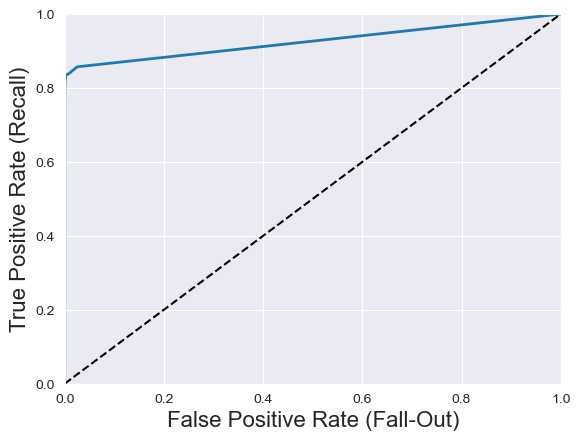

ROC AUC score: 0.926399631480892

[[56858     5]
 [   27    71]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9795    0.9895     56863
           1     0.0673    0.8571    0.1248        98

    accuracy                         0.9793     56961
   macro avg     0.5335    0.9183    0.5572     56961
weighted avg     0.9981    0.9793    0.9880     56961




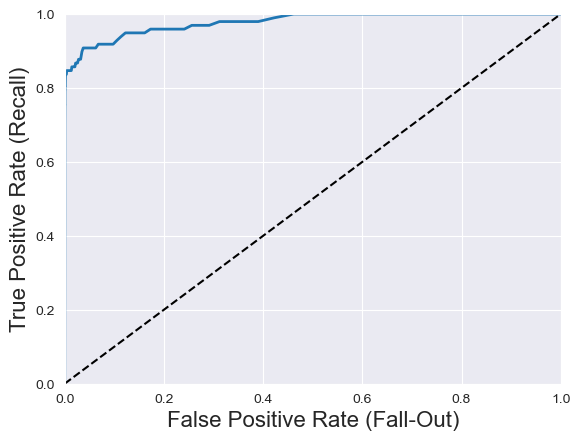

ROC AUC score: 0.978115947854618

[[55699  1164]
 [   14    84]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56961
   macro avg     0.9142    0.8213    0.8619     56961
weighted avg     0.9991    0.9992    0.9991     56961




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


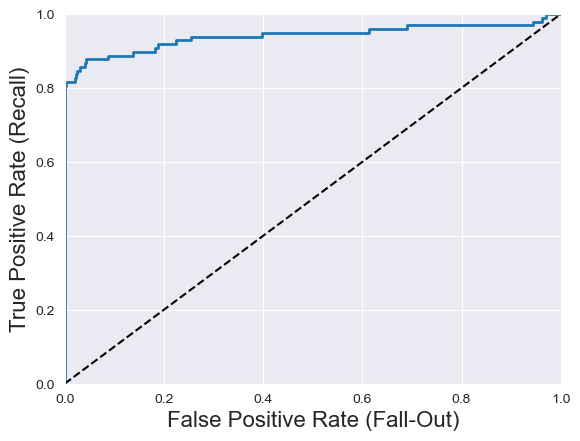

ROC AUC score: 0.9403352920930256

[[56850    13]
 [   35    63]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56863
           1     0.9545    0.6429    0.7683        98

    accuracy                         0.9993     56961
   macro avg     0.9770    0.8214    0.8840     56961
weighted avg     0.9993    0.9993    0.9993     56961




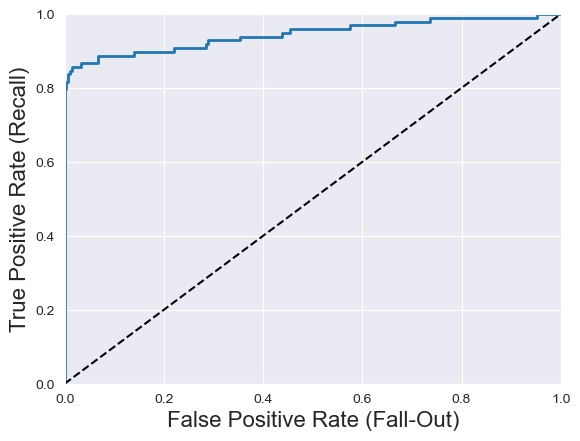

ROC AUC score: 0.945701214555428

[[56860     3]
 [   35    63]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9452    0.7041    0.8070        98

    accuracy                         0.9994     56961
   macro avg     0.9723    0.8520    0.9034     56961
weighted avg     0.9994    0.9994    0.9994     56961




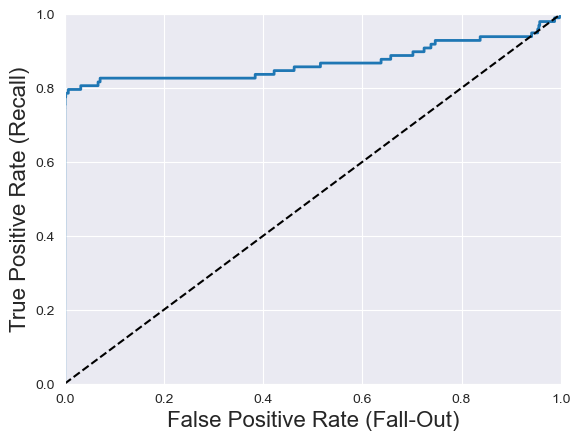

ROC AUC score: 0.8693337226208212

[[56859     4]
 [   29    69]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8947    0.6939    0.7816        98

    accuracy                         0.9993     56961
   macro avg     0.9471    0.8469    0.8906     56961
weighted avg     0.9993    0.9993    0.9993     56961




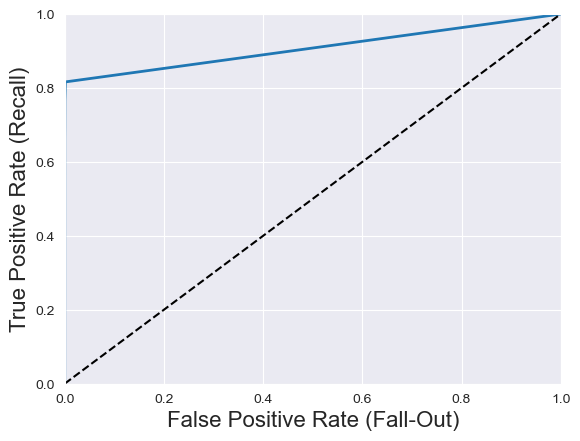

ROC AUC score: 0.9079804951894762

[[56855     8]
 [   30    68]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9589    0.9789     56863
           1     0.0327    0.8061    0.0629        98

    accuracy                         0.9587     56961
   macro avg     0.5162    0.8825    0.5209     56961
weighted avg     0.9980    0.9587    0.9773     56961




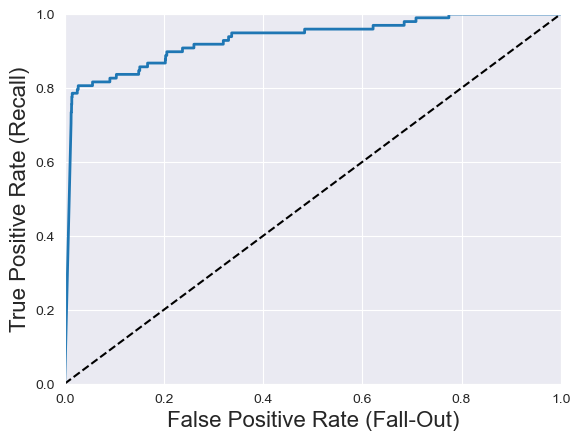

ROC AUC score: 0.9318052124565775

[[54527  2336]
 [   19    79]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995     56863
           1     0.7750    0.6327    0.6966        98

    accuracy                         0.9991     56961
   macro avg     0.8872    0.8162    0.8481     56961
weighted avg     0.9990    0.9991    0.9990     56961




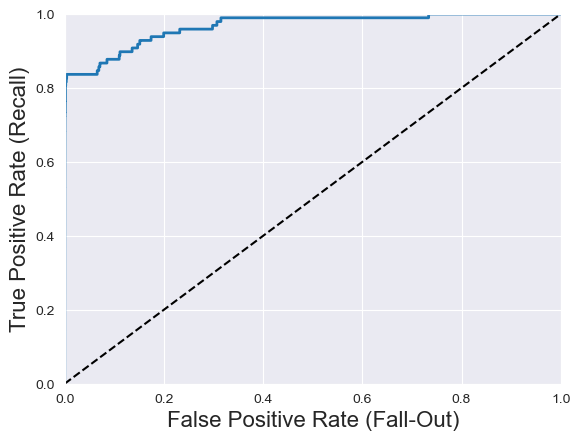

ROC AUC score: 0.967029598889131

[[56845    18]
 [   36    62]]

============ qda_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9660    0.9825     56863
           1     0.0397    0.8163    0.0757        98

    accuracy                         0.9657     56961
   macro avg     0.5197    0.8911    0.5291     56961
weighted avg     0.9980    0.9657    0.9810     56961




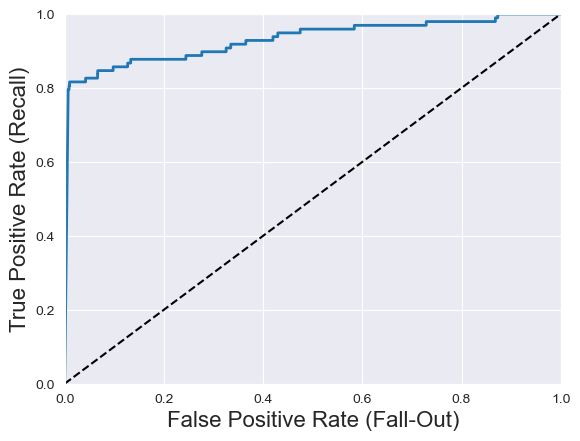

ROC AUC score: 0.931189697974401

[[54927  1936]
 [   18    80]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8987    0.7245    0.8023        98

    accuracy                         0.9994     56961
   macro avg     0.9491    0.8622    0.9010     56961
weighted avg     0.9994    0.9994    0.9994     56961




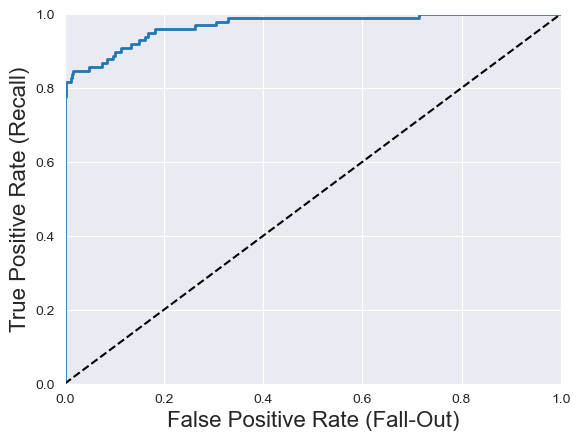

ROC AUC score: 0.9695325714831242

[[56855     8]
 [   27    71]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56863
           1     0.9375    0.7653    0.8427        98

    accuracy                         0.9995     56961
   macro avg     0.9685    0.8826    0.9212     56961
weighted avg     0.9995    0.9995    0.9995     56961




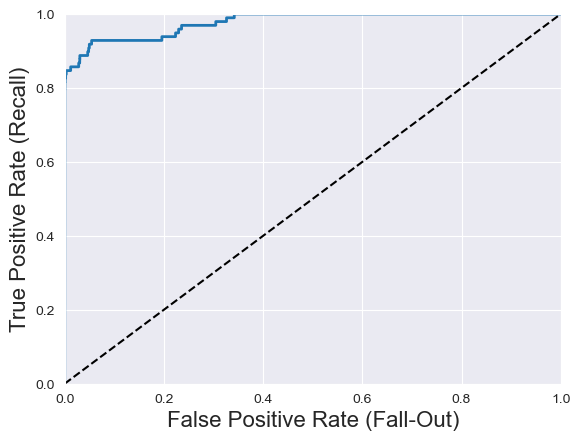

ROC AUC score: 0.9779187319899207

[[56858     5]
 [   23    75]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8750    0.7857    0.8280        98

    accuracy                         0.9994     56961
   macro avg     0.9373    0.8928    0.9138     56961
weighted avg     0.9994    0.9994    0.9994     56961




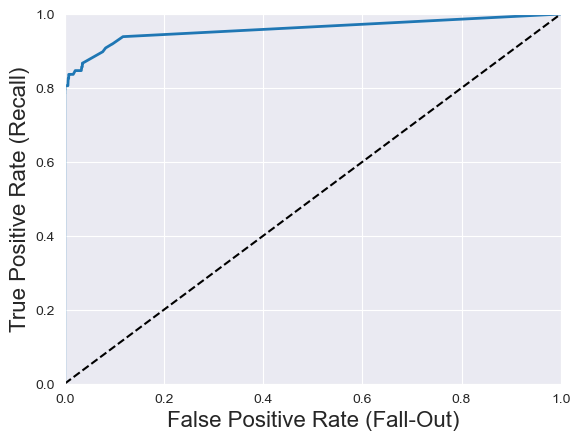

ROC AUC score: 0.9590715170404198

[[56852    11]
 [   21    77]]



In [130]:
eval_dict_hours_log = dict()

for i, m in enumerate(models):
    eval_dict_hours_log[model_names[i]] = model_tester(m, model_names[i], X_train=X_train_hour_amt_robust_log, y_train=y_train,\
                                                       X_val=X_val_hour_amt_robust_log, y_val=y_val)                                                       

In [131]:
eval_df_hour_log = pd.DataFrame(data=eval_dict_hours_log.values(), index=eval_dict_hours_log.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [132]:
eval_df_hour_log

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.862201    0.934211  0.724490  0.816092                5   
brf_clf            0.918336    0.067308  0.857143  0.124814             1164   
lr_clf             0.821314    0.828947  0.642857  0.724138               13   
svc_rbf_clf        0.821402    0.954545  0.642857  0.768293                3   
svc_ploy_clf       0.852006    0.945205  0.704082  0.807018                4   
knn_clf            0.846868    0.894737  0.693878  0.781609                8   
gnb_clf            0.882521    0.032712  0.806122  0.062873             2336   
ada_clf            0.816168    0.775000  0.632653  0.696629               18   
qda_clf            0.891140    0.039683  0.816327  0.075686             1936   
mlp_clf            0.862175    0.898734  0.724490  0.802260                8   
xgb_clf            0.882609    0.937500  0.765306  0.842697                5   
xgbrf_clf          0.892760    0.875000  0.785714  0.827957               11   

              false_negatives  train_time  test_time  
rf_clf                     27  109.249538   0.457103  
brf_clf                    14    2.984677   0.304069  
lr_clf                     35    1.445327   0.012003  
svc_rbf_clf                35  840.486353  10.827133  
svc_ploy_clf               29  143.183239   0.882200  
knn_clf                    30    0.062014   8.307884  
gnb_clf                    19    0.149033   0.050012  
ada_clf                    36   45.215008   0.561127  
qda_clf                    18    0.321073   0.073016  
mlp_clf                    27   20.630900   0.048011  
xgb_clf                    23    9.241967   0.034008  
xgbrf_clf                  21    9.829204   0.036008

In [134]:
three_datasets = pd.concat([eval_df_time, eval_df_hour, eval_df_hour_log], axis=1)

In [138]:
three_datasets.to_excel("three_datasets.xlsx")

In [235]:
class_weight = {
    0 : 10,
    1 : 1
}
rf_clf2 = RandomForestClassifier(class_weight=class_weight)
rf_clf2.fit(X_train_hour_amt_robust_log, y_train)

RandomForestClassifier(class_weight={0: 10, 1: 1})

### No Class weight

In [209]:
y_pr = rf_clf2.predict(X_val_hour_amt_robust_log)

In [233]:
print(metrics.classification_report(y_val, y_pr, digits=4))

              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9103    0.7245    0.8068        98

    accuracy                         0.9994     56961
   macro avg     0.9549    0.8622    0.9033     56961
weighted avg     0.9994    0.9994    0.9994     56961



In [234]:
print(confusion_matrix(y_val, y_pr))

[[56856     7]
 [   27    71]]


In [210]:
fbeta_score(y_val, y_pr, average='binary', beta=10, pos_label=1)

0.7259566713909698

### Class weight 'balanced'

In [18]:
rf_clf2 = RandomForestClassifier(class_weight='balanced')
rf_clf2.fit(X_train_hour_amt_robust_log, y_train)

RandomForestClassifier(class_weight='balanced')

In [19]:
y_pr_bal = rf_clf2.predict(X_val_hour_amt_robust_log)

In [20]:
print(metrics.classification_report(y_val, y_pr_bal, digits=4))

              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9306    0.6837    0.7882        98

    accuracy                         0.9994     56961
   macro avg     0.9650    0.8418    0.8940     56961
weighted avg     0.9993    0.9994    0.9993     56961



In [21]:
print(confusion_matrix(y_val, y_pr_bal))

[[56858     5]
 [   31    67]]


In [24]:
fbeta_score(y_val, y_pr_bal, average='binary', beta=10, pos_label=1)

0.6854740680713127

### Class weighting 0:1 - 1:10 (0:0.1 - 1:0.9)

In [63]:
class_weight = {
    0 : .1,
    1 : .9
}
rf_clf2 = RandomForestClassifier(class_weight=class_weight)
rf_clf2.fit(X_train_hour_amt_robust_log, y_train)

RandomForestClassifier(class_weight={0: 0.1, 1: 0.9})

In [64]:
y_pr_cw2 = rf_clf2.predict(X_val_hour_amt_robust_log)

In [65]:
print(metrics.classification_report(y_val, y_pr_cw2, digits=4))

              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9315    0.6939    0.7953        98

    accuracy                         0.9994     56961
   macro avg     0.9655    0.8469    0.8975     56961
weighted avg     0.9994    0.9994    0.9993     56961



In [66]:
print(confusion_matrix(y_val, y_pr_cw2))

[[56858     5]
 [   30    68]]


In [67]:
fbeta_score(y_val, y_pr_cw2, average='binary', beta=10, pos_label=1)

0.6956345588980046

In [27]:
# old 0:1 - 1:10
print(metrics.classification_report(y_val, y_pr_cw2, digits=4))

              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9333    0.7143    0.8092        98

    accuracy                         0.9994     56961
   macro avg     0.9664    0.8571    0.9045     56961
weighted avg     0.9994    0.9994    0.9994     56961



In [28]:
print(confusion_matrix(y_val, y_pr_cw2))

[[56858     5]
 [   28    70]]


In [29]:
fbeta_score(y_val, y_pr_cw2, average='binary', beta=10, pos_label=1)

0.7159493670886077

### Class weighting 0:10 - 1:1 (0:0.9 - 1:0.1)

In [68]:
class_weight = {
    0 : 0.9,
    1 : 0.1
}
rf_clf2 = RandomForestClassifier(class_weight=class_weight)
rf_clf2.fit(X_train_hour_amt_robust_log, y_train)

RandomForestClassifier(class_weight={0: 0.9, 1: 0.1})

In [69]:
y_pr_cw = rf_clf2.predict(X_val_hour_amt_robust_log)

In [70]:
print(metrics.classification_report(y_val, y_pr_cw, digits=4))

              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9114    0.7347    0.8136        98

    accuracy                         0.9994     56961
   macro avg     0.9555    0.8673    0.9066     56961
weighted avg     0.9994    0.9994    0.9994     56961



In [71]:
print(confusion_matrix(y_val, y_pr_cw))

[[56856     7]
 [   26    72]]


In [72]:
fbeta_score(y_val, y_pr_cw, average='binary', beta=10, pos_label=1)

0.7361068934102643

In [43]:
# old 0:10 - 1:1 
y_pr_cw = rf_clf2.predict(X_val_hour_amt_robust_log)

In [44]:
print(metrics.classification_report(y_val, y_pr_cw, digits=4))

              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56863
           1     0.9241    0.7449    0.8249        98

    accuracy                         0.9995     56961
   macro avg     0.9618    0.8724    0.9123     56961
weighted avg     0.9994    0.9995    0.9994     56961



In [45]:
print(confusion_matrix(y_val, y_pr_cw))

[[56857     6]
 [   25    73]]


In [46]:
fbeta_score(y_val, y_pr_cw, average='binary', beta=10, pos_label=1)

0.7463306002631844

In [47]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [48]:
pos_probs = rf_clf2.predict_proba(X_val_hour_amt_robust_log)

In [54]:
pos_probs[:,1].shape

(56961,)

In [55]:
precision1, recall1, _ = precision_recall_curve(y_val, pos_probs[:,1])
auc_score = auc(recall1, precision1)
auc_score

0.8131297380707706

In [60]:
def plot_pr_curve(recall, precision, label=None):
    plt.plot(recall, precision, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('Recall', fontsize=16) 
    plt.ylabel('Precision', fontsize=16)    
    plt.grid(True)

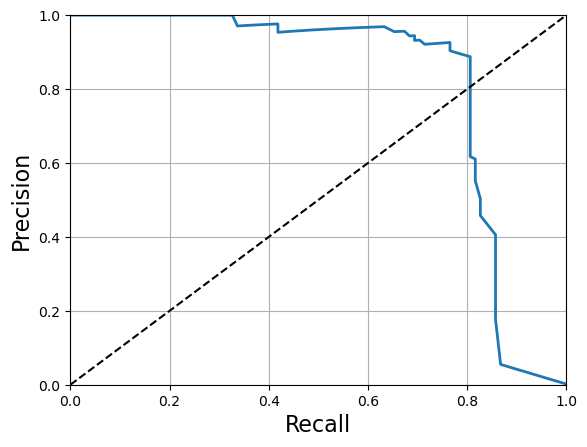

In [61]:
plot_pr_curve(recall1,precision1)
plt.show()

In [211]:
xgb_clf2 = xgb.XGBClassifier()
xgb_clf2.fit(X_train_hour_amt_robust_log, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [212]:
y_pr2 = xgb_clf2.predict(X_val_hour_amt_robust_log)

In [213]:
fbeta_score(y_val, y_pr2, average='binary', beta=10, pos_label=1)

0.7667004048582996

# Mutual information on Hours-Amount(Robust/Log)

In [139]:
mi_scores_hour_rob_log = make_mi_scores(X=X_train_hour_amt_robust_log, y=y_train)

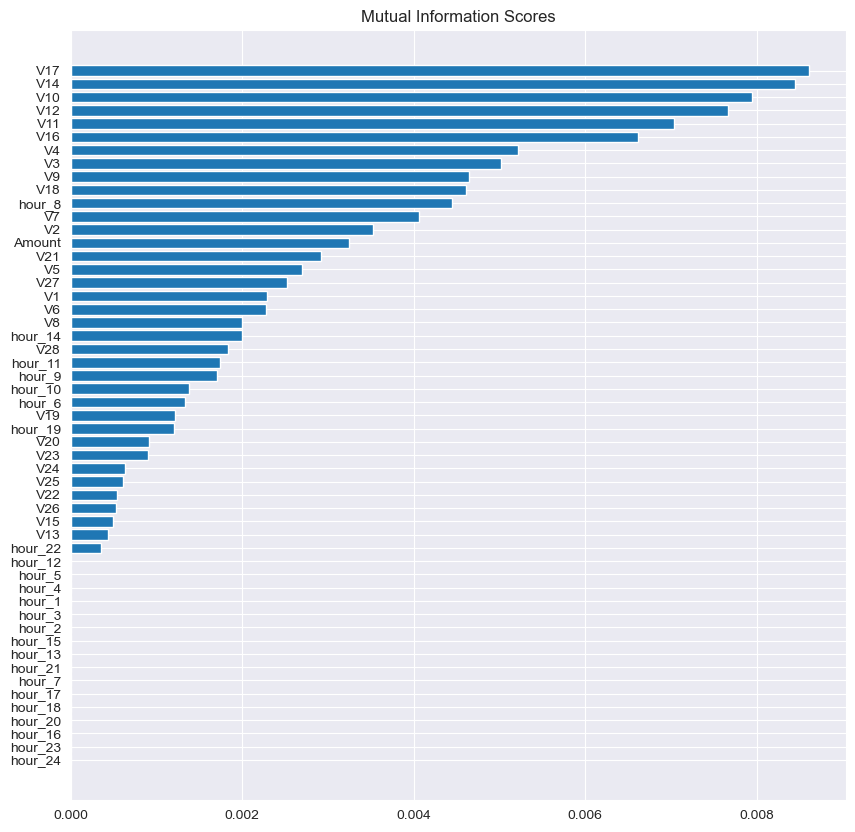

In [140]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plot_mi_scores(mi_scores_hour_rob_log)

# "unimportant" features removed

In [155]:
features_with_zero_mutual_info = mi_scores_hour_rob_log[~(mi_scores_hour_rob_log>0)].index

In [164]:
X_train_pruned = X_train_hour_amt_robust_log.drop(features_with_zero_mutual_info, axis=1)
X_val_pruned = X_val_hour_amt_robust_log.drop(features_with_zero_mutual_info, axis=1)
X_train_pruned

V1        V2        V3        V4        V5        V6        V7  \
109011 -2.108259  1.173406  1.614294  0.482867  0.067209 -0.191013  0.191246   
280683  2.313997 -1.311064 -1.421228 -1.724356 -1.003480 -0.912621 -0.898765   
158318  2.104946  0.155284 -1.402870  0.311489  0.504248 -0.690870  0.138943   
243733  2.072408 -0.015687 -1.310880  0.373435 -0.063476 -1.380722  0.243699   
177016  2.046409  0.156335 -2.006987  0.384525  0.604029 -0.756561  0.232367   
...          ...       ...       ...       ...       ...       ...       ...   
3441   -0.415022  0.713439  1.221551 -2.108216  0.187067 -1.281616  1.118548   
233802  1.993864 -0.516866 -0.620118  0.129845 -0.285128  0.395044 -0.822358   
85418  -1.497933  0.657921  1.581568 -0.024286  0.584698  1.303031  0.609212   
29062   1.069777  0.072105  0.496540  1.505318 -0.380277 -0.370243  0.100551   
17677  -0.598120  0.775041  1.823394  0.312991 -0.096171 -0.391452  0.499351   

              V8        V9       V10  ...       V28    Amount  hour_6  hour_8  \
109011 -1.705859 -0.177615  0.022894  ...  0.215298 -0.264854       0       0   
280683 -0.221952 -1.658076  1.890293  ... -0.076422 -0.268637       0       0   
158318 -0.417801  1.894584 -0.500615  ... -0.053868 -0.297615       0       0   
243733 -0.394350  0.631048  0.021983  ... -0.058972 -0.292011       0       0   
177016 -0.230789  0.072474 -0.191523  ... -0.053246 -0.294121       0       0   
...          ...       ...       ...  ...       ...       ...     ...     ...   
3441   -0.345326  0.463473 -0.999876  ... -0.020422 -0.297615       0       0   
233802  0.231591  0.995898  0.212619  ... -0.058552 -0.280177       0       0   
85418   0.135561  0.452745  0.108640  ...  0.045178 -0.256587       0       0   
29062  -0.026687  0.319684 -0.131553  ...  0.024886 -0.253794       0       0   
17677   0.071224 -0.017496 -0.512312  ...  0.206366 -0.278314       0       0   

        hour_9  hour_10  hour_11  hour_14  hour_19  hour_22  
109011       0        0        0        0        0        0  
280683       0        0        0        0        0        0  
158318       0        0        0        0        0        0  
243733       0        0        0        0        1        0  
177016       0        0        1        0        0        0  
...        ...      ...      ...      ...      ...      ...  
3441         0        0        0        0        0        0  
233802       0        0        0        0        0        0  
85418        0        0        0        0        0        0  
29062        0        1        0        0        0        0  
17677        1        0        0        0        0        0  

[170884 rows x 37 columns]

============ rf_clf ============
None
'RandomForestClassifier' object has no attribute 'coef_'
The rf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56863
           1     0.9250    0.7551    0.8315        98

    accuracy                         0.9995     56961
   macro avg     0.9623    0.8775    0.9156     56961
weighted avg     0.9994    0.9995    0.9994     56961




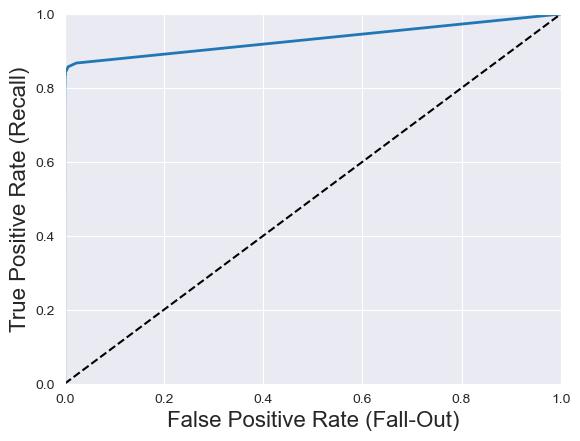

ROC AUC score: 0.9318740316413923

[[56857     6]
 [   24    74]]

============ brf_clf ============


C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\marke\anacond

None
'BalancedRandomForestClassifier' object has no attribute 'coef_'
The brf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9998    0.9759    0.9877     56863
           1     0.0591    0.8776    0.1108        98

    accuracy                         0.9758     56961
   macro avg     0.5295    0.9267    0.5493     56961
weighted avg     0.9982    0.9758    0.9862     56961




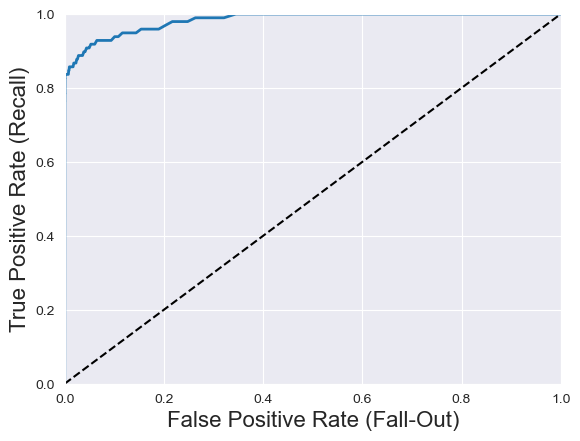

ROC AUC score: 0.9832132332383563

[[55495  1368]
 [   12    86]]

============ lr_clf ============
'LogisticRegression' object has no attribute 'feature_importances_'
The lr_clf model does not have a feature importance parameter
Per-column arrays must each be 1-dimensional
The lr_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56863
           1     0.8205    0.6531    0.7273        98

    accuracy                         0.9992     56961
   macro avg     0.9100    0.8264    0.8634     56961
weighted avg     0.9991    0.9992    0.9991     56961




C:\Users\marke\anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


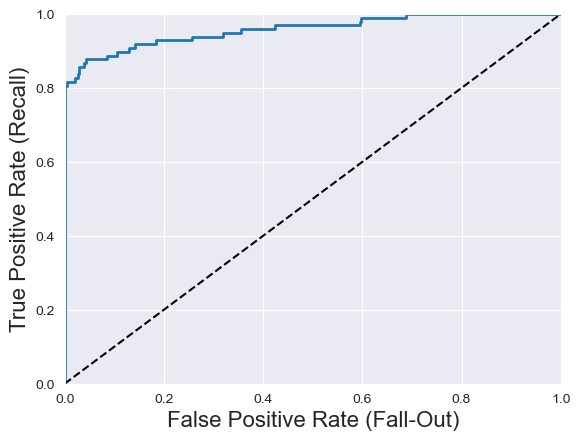

ROC AUC score: 0.9583013164114105

[[56849    14]
 [   34    64]]

============ svc_rbf_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_rbf_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_rbf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     56863
           1     0.9545    0.6429    0.7683        98

    accuracy                         0.9993     56961
   macro avg     0.9770    0.8214    0.8840     56961
weighted avg     0.9993    0.9993    0.9993     56961




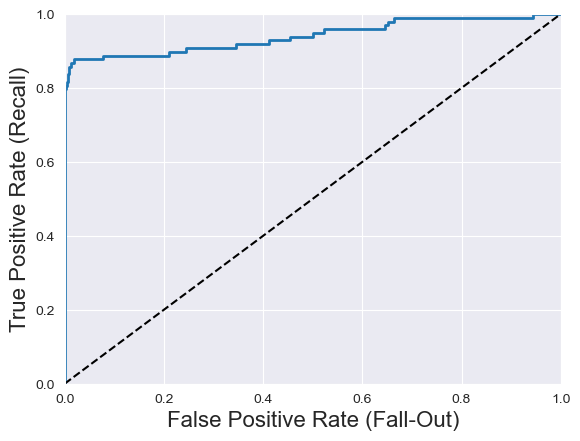

ROC AUC score: 0.9414152239162727

[[56860     3]
 [   35    63]]

============ svc_ploy_clf ============
'SVC' object has no attribute 'feature_importances_'
The svc_ploy_clf model does not have a feature importance parameter
coef_ is only available when using a linear kernel
The svc_ploy_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9200    0.7041    0.7977        98

    accuracy                         0.9994     56961
   macro avg     0.9597    0.8520    0.8987     56961
weighted avg     0.9994    0.9994    0.9993     56961




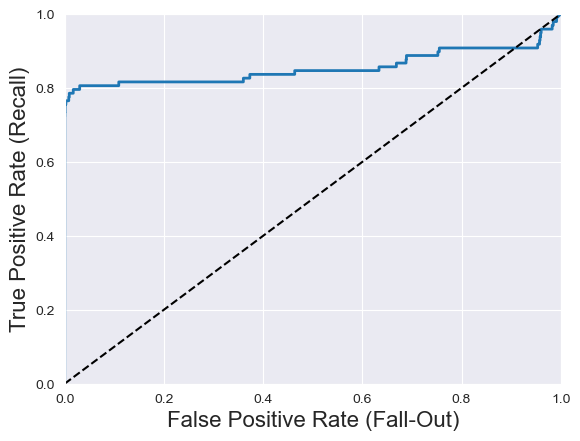

ROC AUC score: 0.8540088476169181

[[56857     6]
 [   29    69]]

============ knn_clf ============
'KNeighborsClassifier' object has no attribute 'feature_importances_'
The knn_clf model does not have a feature importance parameter
'KNeighborsClassifier' object has no attribute 'coef_'
The knn_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.8947    0.6939    0.7816        98

    accuracy                         0.9993     56961
   macro avg     0.9471    0.8469    0.8906     56961
weighted avg     0.9993    0.9993    0.9993     56961




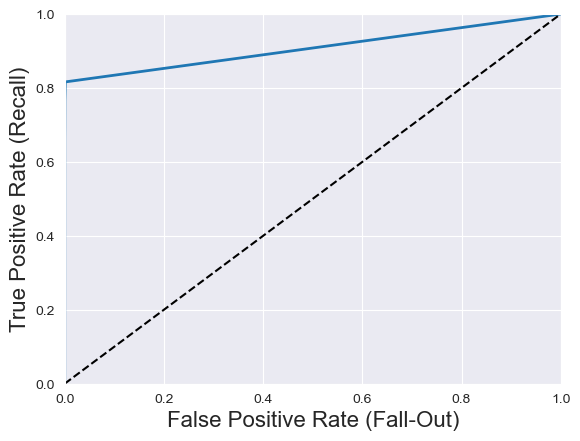

ROC AUC score: 0.9079971840661066

[[56855     8]
 [   30    68]]

============ gnb_clf ============
'GaussianNB' object has no attribute 'feature_importances_'
The gnb_clf model does not have a feature importance parameter
'GaussianNB' object has no attribute 'coef_'
The gnb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9769    0.9882     56863
           1     0.0568    0.8061    0.1061        98

    accuracy                         0.9766     56961
   macro avg     0.5282    0.8915    0.5471     56961
weighted avg     0.9980    0.9766    0.9866     56961




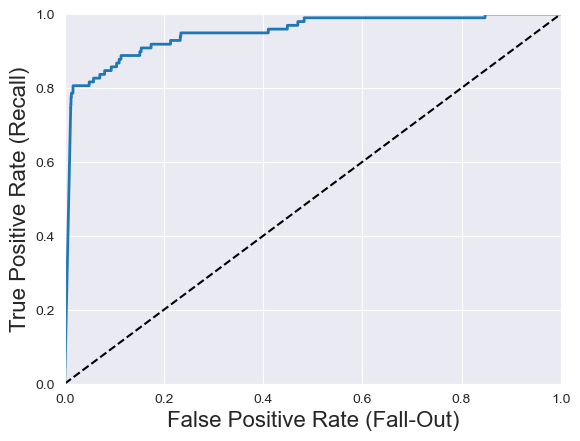

ROC AUC score: 0.9488487725779864

[[55551  1312]
 [   19    79]]

============ ada_clf ============
None
'AdaBoostClassifier' object has no attribute 'coef_'
The ada_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995     56863
           1     0.7750    0.6327    0.6966        98

    accuracy                         0.9991     56961
   macro avg     0.8872    0.8162    0.8481     56961
weighted avg     0.9990    0.9991    0.9990     56961




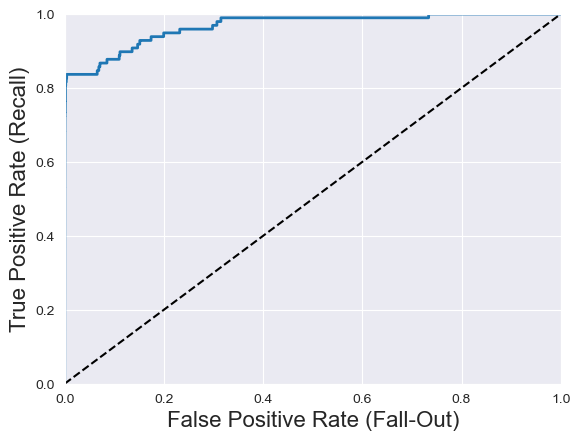

ROC AUC score: 0.967029598889131

[[56845    18]
 [   36    62]]

============ qda_clf ============
'QuadraticDiscriminantAnalysis' object has no attribute 'feature_importances_'
The qda_clf model does not have a feature importance parameter
'QuadraticDiscriminantAnalysis' object has no attribute 'coef_'
The qda_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9997    0.9803    0.9899     56863
           1     0.0666    0.8163    0.1231        98

    accuracy                         0.9800     56961
   macro avg     0.5331    0.8983    0.5565     56961
weighted avg     0.9981    0.9800    0.9884     56961




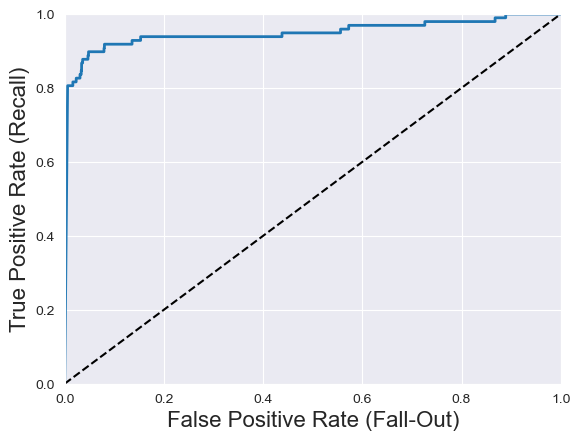

ROC AUC score: 0.9487202861729607

[[55741  1122]
 [   18    80]]

============ mlp_clf ============
'MLPClassifier' object has no attribute 'feature_importances_'
The mlp_clf model does not have a feature importance parameter
'MLPClassifier' object has no attribute 'coef_'
The mlp_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8721    0.7653    0.8152        98

    accuracy                         0.9994     56961
   macro avg     0.9358    0.8826    0.9075     56961
weighted avg     0.9994    0.9994    0.9994     56961




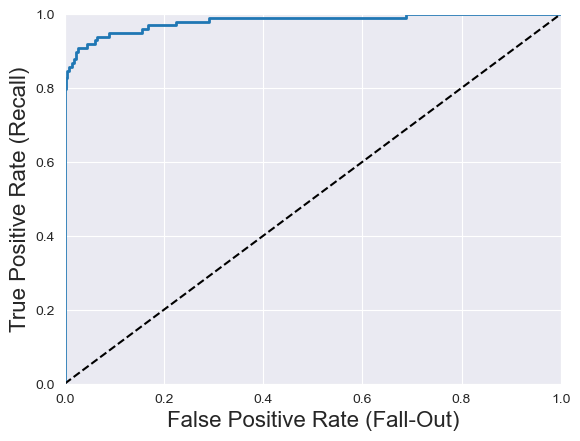

ROC AUC score: 0.9803907494095189

[[56852    11]
 [   23    75]]

============ xgb_clf ============
None
Coefficients are not defined for Booster type None
The xgb_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56863
           1     0.9487    0.7551    0.8409        98

    accuracy                         0.9995     56961
   macro avg     0.9741    0.8775    0.9203     56961
weighted avg     0.9995    0.9995    0.9995     56961




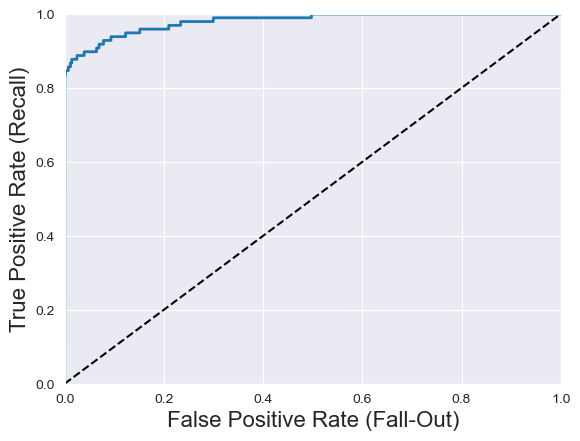

ROC AUC score: 0.9804052848827131

[[56859     4]
 [   24    74]]

============ xgbrf_clf ============
None
Coefficients are not defined for Booster type None
The xgbrf_clf model does not have a coef parameter
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8851    0.7857    0.8324        98

    accuracy                         0.9995     56961
   macro avg     0.9423    0.8928    0.9161     56961
weighted avg     0.9994    0.9995    0.9994     56961




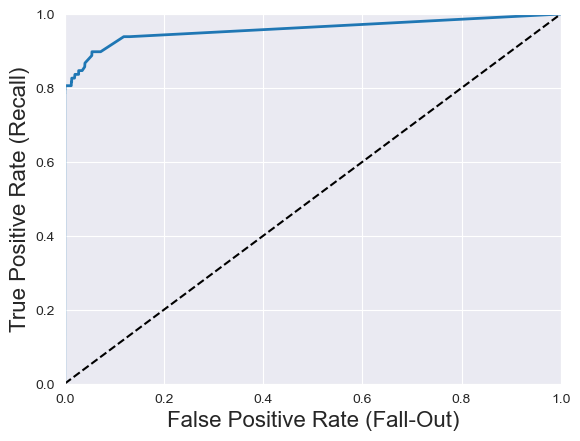

ROC AUC score: 0.95832814422922

[[56853    10]
 [   21    77]]



In [165]:
eval_dict_hours_log_pruned = dict()

for i, m in enumerate(models):
    eval_dict_hours_log_pruned[model_names[i]] = model_tester(m, model_names[i], X_train=X_train_pruned, y_train=y_train,\
                                                       X_val=X_val_pruned, y_val=y_val)                                                       

In [166]:
eval_df_hour_log_pruned = pd.DataFrame(data=eval_dict_hours_log_pruned.values(), index=eval_dict_hours_log_pruned.keys(),\
                       columns=['bal_acc_score','precisions', 'recalls', 'f1', 'false_positives', 'false_negatives', 'train_time', 'test_time'])

In [167]:
eval_df_hour_log_pruned

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.877498    0.925000  0.755102  0.831461                6   
brf_clf            0.926747    0.059147  0.877551  0.110825             1368   
lr_clf             0.826408    0.820513  0.653061  0.727273               14   
svc_rbf_clf        0.821402    0.954545  0.642857  0.768293                3   
svc_ploy_clf       0.851988    0.920000  0.704082  0.797688                6   
knn_clf            0.846868    0.894737  0.693878  0.781609                8   
gnb_clf            0.891525    0.056794  0.806122  0.106111             1312   
ada_clf            0.816168    0.775000  0.632653  0.696629               18   
qda_clf            0.898297    0.066556  0.816327  0.123077             1122   
mlp_clf            0.882556    0.872093  0.765306  0.815217               11   
xgb_clf            0.877516    0.948718  0.755102  0.840909                4   
xgbrf_clf          0.892769    0.885057  0.785714  0.832432               10   

              false_negatives  train_time  test_time  
rf_clf                     24  124.157118   0.378087  
brf_clf                    12    2.971672   0.287065  
lr_clf                     34    1.121255   0.009001  
svc_rbf_clf                35  810.481097  10.069014  
svc_ploy_clf               29   96.034715   0.733166  
knn_clf                    30    0.044010   6.377061  
gnb_clf                    19    0.100023   0.036008  
ada_clf                    36   42.380308   0.418094  
qda_clf                    18    0.173039   0.055012  
mlp_clf                    23   15.932821   0.039009  
xgb_clf                    24    7.894790   0.040009  
xgbrf_clf                  21    9.154264   0.027006

In [168]:
eval_df_hour_log_pruned - eval_df_hour_log

bal_acc_score  precisions   recalls        f1  false_positives  \
rf_clf             0.015297   -0.009211  0.030612  0.015369                1   
brf_clf            0.008410   -0.008161  0.020408 -0.013990              204   
lr_clf             0.005093   -0.008435  0.010204  0.003135                1   
svc_rbf_clf        0.000000    0.000000  0.000000  0.000000                0   
svc_ploy_clf      -0.000018   -0.025205  0.000000 -0.009330                2   
knn_clf            0.000000    0.000000  0.000000  0.000000                0   
gnb_clf            0.009004    0.024081  0.000000  0.043238            -1024   
ada_clf            0.000000    0.000000  0.000000  0.000000                0   
qda_clf            0.007158    0.026873  0.000000  0.047391             -814   
mlp_clf            0.020382   -0.026641  0.040816  0.012958                3   
xgb_clf           -0.005093    0.011218 -0.010204 -0.001788               -1   
xgbrf_clf          0.000009    0.010057  0.000000  0.004475               -1   

              false_negatives  train_time  test_time  
rf_clf                     -3   14.907580  -0.079017  
brf_clf                    -2   -0.013005  -0.017004  
lr_clf                     -1   -0.324072  -0.003001  
svc_rbf_clf                 0  -30.005256  -0.758118  
svc_ploy_clf                0  -47.148524  -0.149034  
knn_clf                     0   -0.018004  -1.930822  
gnb_clf                     0   -0.049010  -0.014004  
ada_clf                     0   -2.834701  -0.143033  
qda_clf                     0   -0.148033  -0.018004  
mlp_clf                    -4   -4.698079  -0.009002  
xgb_clf                     1   -1.347177   0.006001  
xgbrf_clf                   0   -0.674940  -0.009001

## SMOTE

OBS: I go with standard one. There are a few options for only numerical varaibles. In case we decide that $hours $ variable is categorical we can choose $SMOTENC$

In [142]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE, ADASYN
X_smotenc_train, y_smotenc_train = SMOTE().fit_resample(X_train_hour_amt_robust_log, y_train)
print(sorted(Counter(y_smotenc_train).items()))

[(0, 170589), (1, 170589)]


In [19]:
labels = pd.DataFrame({'Class': y_smote_train})

smote_train = pd.concat([X_smote_train, labels], axis=1)
smote_train.shape

(341178, 31)

# 4.5.1 Balanced dataset analysis

In [16]:
# #######This is maybe for later before model selection, so we can make EDA between the target feature and the other features
# # defining the target varible for each set
y_train = raw_train.pop('Class')
# y_val = raw_val.pop('Class')
# y_test = raw_test.pop('Class')

## RandomOverSampler

The most naive strategy. $RandomOverSampler()$ generates new samples by randomly sampling with replacement the current available samples.

(If repeating samples is an issue, the parameter shrinkage allows to create a smoothed bootstrap. However, the original data needs to be numerical.) 

In [17]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_ros_train, y_ros_train = ros.fit_resample(raw_train, y_train)
from collections import Counter
print(sorted(Counter(y_ros_train).items()))

[(0, 170589), (1, 170589)]


In [73]:
labels = pd.DataFrame({'Class': y_ros_train})

ros_train = pd.concat([X_ros_train, labels], axis=1)
ros_train.head()

Time        V1        V2        V3        V4        V5        V6  \
0   71174.0 -2.108259  1.173406  1.614294  0.482867  0.067209 -0.191013   
1  169683.0  2.313997 -1.311064 -1.421228 -1.724356 -1.003480 -0.912621   
2  111127.0  2.104946  0.155284 -1.402870  0.311489  0.504248 -0.690870   
3  152052.0  2.072408 -0.015687 -1.310880  0.373435 -0.063476 -1.380722   
4  123008.0  2.046409  0.156335 -2.006987  0.384525  0.604029 -0.756561   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.191246 -1.705859 -0.177615  ...  1.520624 -0.388595  0.260114  0.340667   
1 -0.898765 -0.221952 -1.658076  ...  0.089446  0.664605  0.029245 -0.347503   
2  0.138943 -0.417801  1.894584  ...  0.107745  0.759527 -0.022144  0.465282   
3  0.243699 -0.394350  0.631048  ...  0.243262  0.858393  0.003403  0.077370   
4  0.232367 -0.230789  0.072474  ...  0.326565  1.165945 -0.109465  0.793698   

        V25       V26       V27       V28  Amount  Class  
0  0.400474 -0.413089 -0.348291  0.215298   19.99      0  
1  0.069152  0.074159 -0.024483 -0.076422   15.00      0  
2  0.402861 -0.478955 -0.016524 -0.053868    1.00      0  
3  0.259102 -0.110464 -0.021166 -0.058972    1.99      0  
4  0.377195  0.837559 -0.075171 -0.053246    1.57      0  

[5 rows x 31 columns]

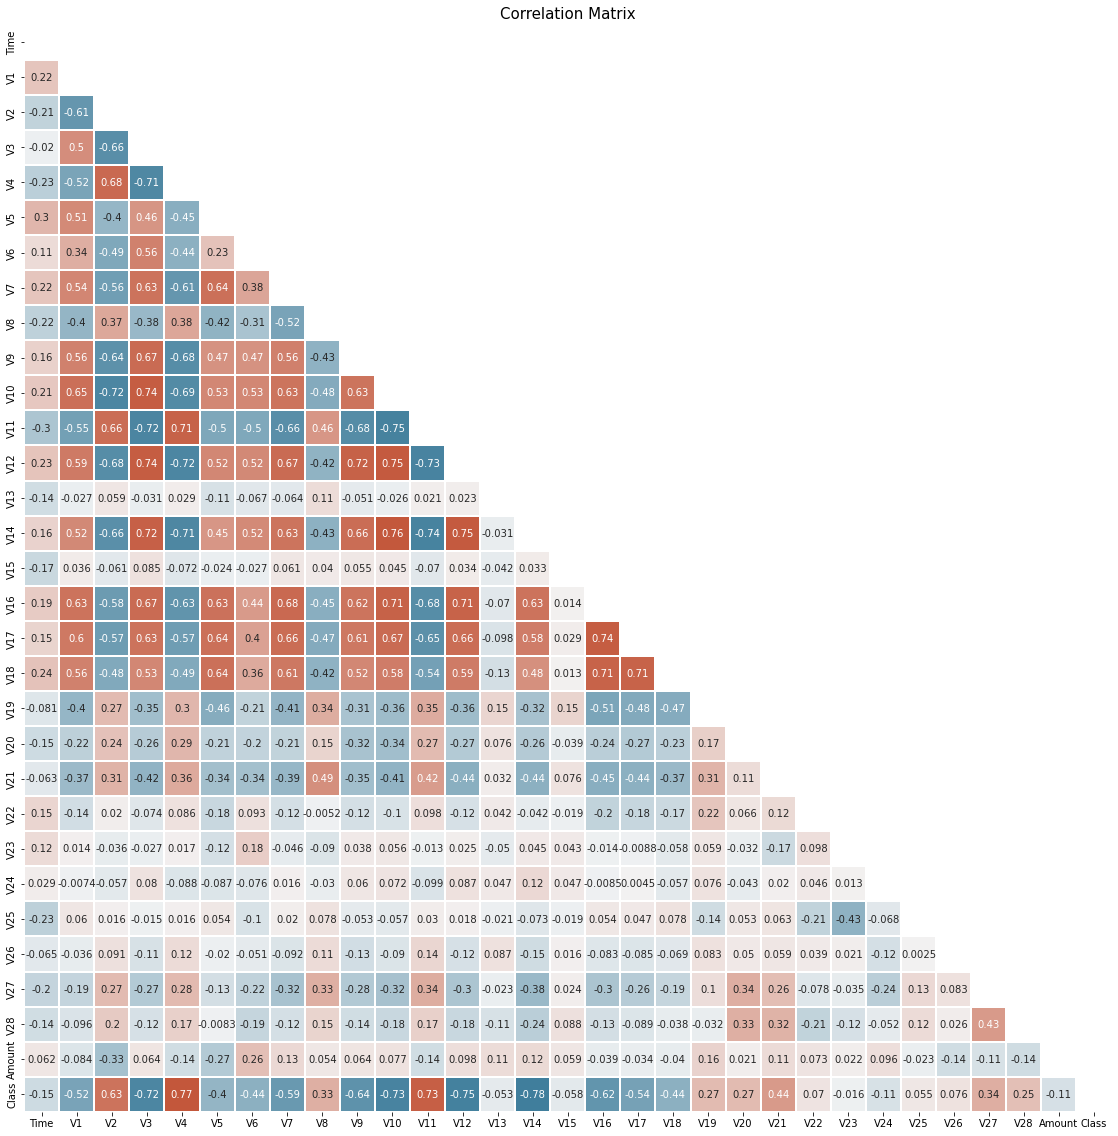

In [75]:
features = [
    'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
    'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
    'Class'
]

correlation_matrix = ros_train[features].corr(method="spearman") # pearson / spearman

#from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Correlation Matrix", fontsize=15)

In [81]:
correlations = ros_train.corr(method='spearman')['Class']
sorted_correlations = correlations.sort_values(ascending=False)

print(sorted_correlations)

Class     1.000000
V4        0.772952
V11       0.725250
V2        0.630754
V21       0.437402
V27       0.341694
V8        0.333869
V20       0.270050
V19       0.269975
V28       0.253732
V26       0.075907
V22       0.069819
V25       0.055193
V23      -0.016456
V13      -0.052662
V15      -0.057519
V24      -0.108174
Amount   -0.114506
Time     -0.153994
V5       -0.400773
V6       -0.440430
V18      -0.440947
V1       -0.522245
V17      -0.538110
V7       -0.591633
V16      -0.618229
V9       -0.635883
V3       -0.717113
V10      -0.734595
V12      -0.754130
V14      -0.781623
Name: Class, dtype: float64


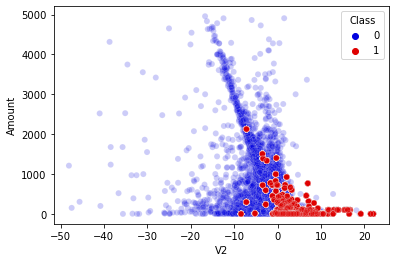

In [95]:
sns.scatterplot(x=ros_train['V2'], y=ros_train['Amount'], hue=ros_train['Class'], palette=colors, alpha = 0.2)

# show the plot
plt.show()

## Observations:
- after balancing training dataset with RandomOverSampler() we've got much stronger correlations between 'Class' and other features,
- on the scatterplot we can see that RandomOverSamler() copied instances of fraud transactions. 

## SMOTE

OBS: I go with standard one. There are a few options for only numerical varaibles. In case we decide that $hours $ variable is categorical we can choose $SMOTENC$

In [18]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE, ADASYN
X_smotenc_train, y_smotenc_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_smote_train).items()))

[(0, 170589), (1, 170589)]


In [19]:
labels = pd.DataFrame({'Class': y_smote_train})

smote_train = pd.concat([X_smote_train, labels], axis=1)
smote_train.shape

(341178, 31)

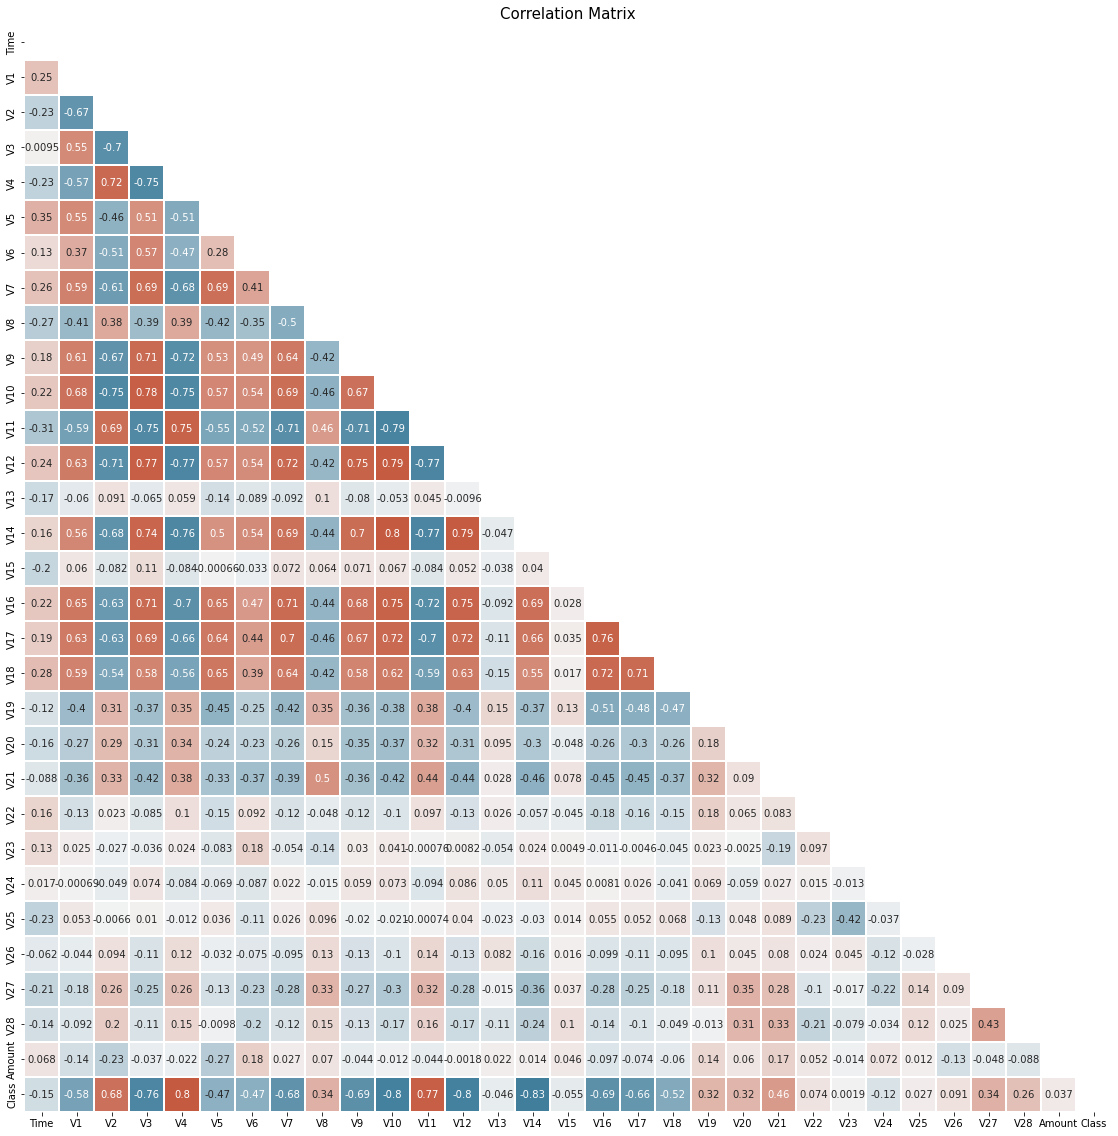

In [104]:
correlation_matrix = smote_train[features].corr(method="spearman") # pearson / spearman

#from matplotlib.colors import SymLogNorm

f, ax = plt.subplots(figsize=(20, 20))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Correlation Matrix", fontsize=15)

In [105]:
correlations = smote_train.corr(method='spearman')['Class']
sorted_correlations = correlations.sort_values(ascending=False)

print(sorted_correlations)

Class     1.000000
V4        0.801585
V11       0.770547
V2        0.679177
V21       0.455066
V8        0.344386
V27       0.343402
V19       0.317272
V20       0.315204
V28       0.261136
V26       0.091276
V22       0.074167
Amount    0.037352
V25       0.026560
V23       0.001851
V13      -0.046080
V15      -0.054691
V24      -0.116743
Time     -0.151290
V5       -0.466059
V6       -0.474893
V18      -0.516046
V1       -0.575589
V17      -0.656395
V7       -0.677102
V9       -0.692713
V16      -0.693784
V3       -0.763920
V10      -0.801194
V12      -0.805000
V14      -0.831524
Name: Class, dtype: float64


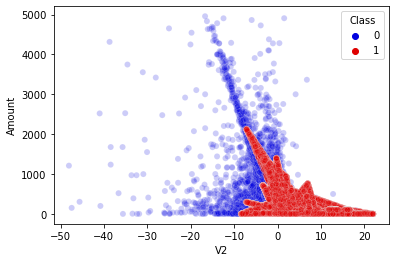

In [106]:
sns.scatterplot(x=smote_train['V2'], y=smote_train['Amount'], hue=smote_train['Class'], palette=colors, alpha = 0.2)

# show the plot
plt.show()

In [35]:
from sklearn.feature_selection import mutual_info_regression

In [36]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.columns:
        mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=0)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [37]:
mi_scores = make_mi_scores(X=X_train, y=y_train)

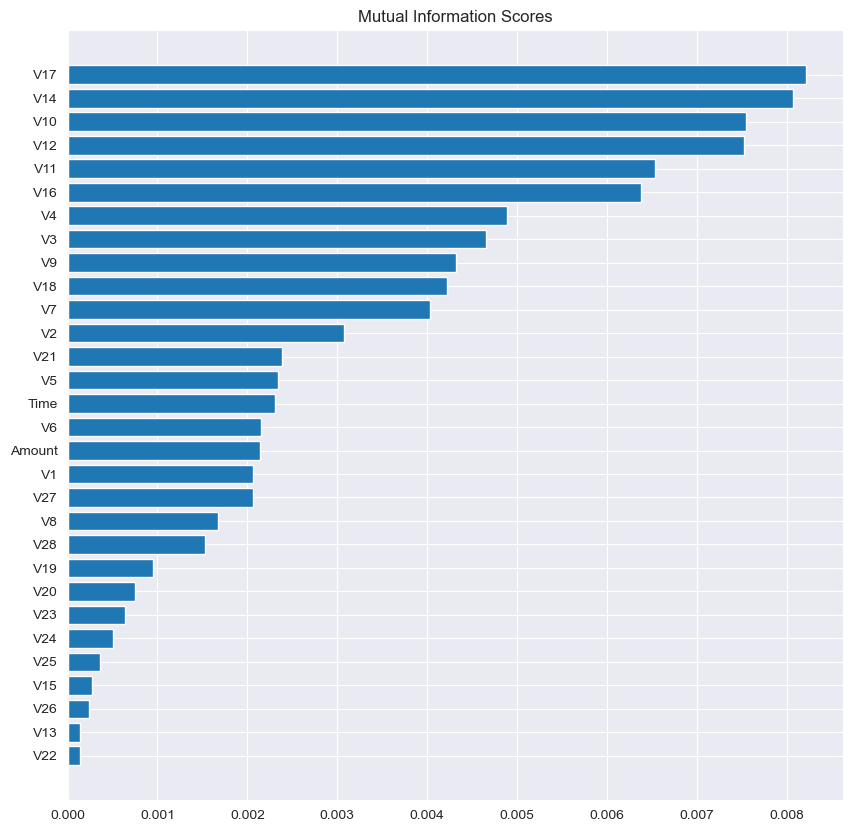

In [39]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plot_mi_scores(mi_scores)

# 4.6. The $Time$ variable analysis

In [72]:
raw_train.Time.describe()

count    170884.000000
mean      94939.372885
std       47506.712210
min           0.000000
25%       54277.750000
50%       84907.500000
75%      139422.250000
max      172792.000000
Name: Time, dtype: float64

In [113]:
df_fraud.head()

Time     V1     V2      V3     V4     V5     V6      V7    V8  \
84543   60353.000 -3.975  0.582  -1.880  4.319 -3.024  1.241  -1.910 0.661   
9509    14152.000 -4.711  8.636 -15.496 10.313 -4.351 -3.323 -10.788 5.060   
276071 166883.000  2.092 -0.757  -1.192 -0.755 -0.620 -0.322  -1.083 0.117   
262560 160537.000  0.568  3.309  -6.631  6.395 -0.054 -2.397  -2.792 0.515   
50211   44393.000 -4.617  3.663  -5.297  3.881 -3.264 -0.919  -5.715 0.831   

           V9  ...   V21    V22    V23    V24    V25    V26    V27    V28  \
84543  -2.753  ... 0.579  1.397  1.045 -0.304  0.005  0.235  0.962 -0.674   
9509   -5.689  ... 1.991  0.224  0.554 -1.204 -0.451  0.642  1.606  0.722   
276071 -0.141  ... 0.288  0.832  0.142  0.593 -0.196 -0.137  0.020 -0.015   
262560 -3.542  ... 0.614 -0.365 -0.180 -0.523  0.645  0.246  0.903  0.474   
50211  -2.457  ... 2.698 -0.027  0.367 -0.123 -0.300 -0.240 -0.183 -0.073   

        Amount  Class  
84543  454.820      1  
9509     1.000      1  
276071  19.950      1  
262560   4.690      1  
50211    1.000      1  

[5 rows x 31 columns]

<AxesSubplot: xlabel='Time', ylabel='Count'>

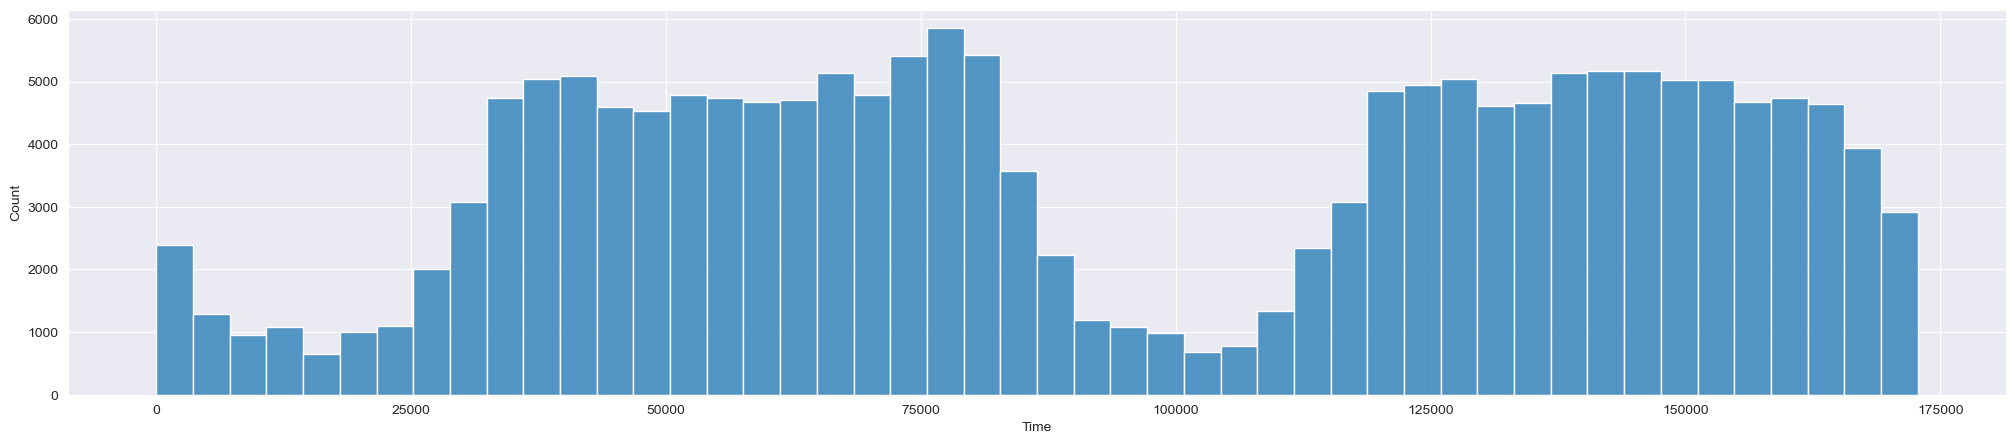

In [75]:
f, ax = plt.subplots(figsize=(25, 5))
sns.histplot(raw_train['Time'], bins = 48)

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- There are two periods when there is much more transactions done.
- $Time$ is in seconds from 0 to 172792 (so it is 2879,8 min -> about 48hours)
- We can assume that the modes are daytimes and the dataset describes two days

In [73]:
m = 172792/60 #minutes
h = m/60

print(f'Minutes {m}')
print(f'Hours: {h}')

Minutes 2879.866666666667
Hours: 47.99777777777778


# 4.6.1. Time distribution for only the fraudulent transactions

In [74]:
df_fraud = raw_train[raw_train['Class'] == 1]
len(df_fraud)

295

<AxesSubplot:xlabel='Time', ylabel='Count'>

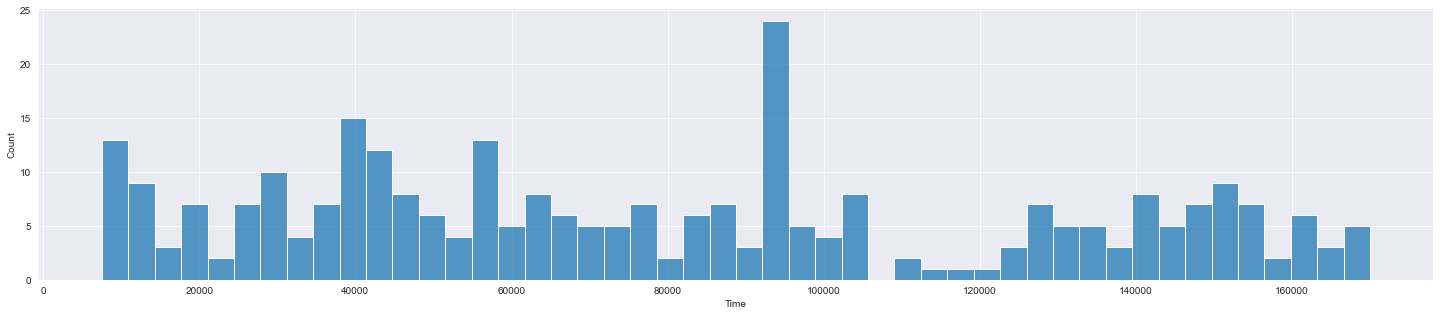

In [406]:
f, ax = plt.subplots(figsize=(25, 5))
sns.histplot(df_fraud['Time'], bins = 48)


### **<code style="background:lightgreen;color:black"> Observations:</code>** 
- There are 295 fraudulent transactions in the training set
- There seems to be no real time pattern for the fraudulent transactions

# ----- DATA PRE-PROCESSING-----

not needed for POC as we run with random forest and we have all numerical values. Further analysis of 'Time' is needed.

In [139]:
# calculate the hour for each value in 'Time'
# // - Floor Division	9//2 = 4

train_t = raw_train
train_t['hour'] = ((((train_t['Time']) // (60 * 60)) % 24) + 1) # I calculate floor to get hours. As a result I get values from 0 to 47. Next I calulate modulo 24 -> I got values from 0 to 23. Last step adding 1 to get values from 1 to 24.
train_t['hour'] = train_t['hour'].astype(int)
print(train_t['hour'].min(), train_t['hour'].max())

1 24


<AxesSubplot: xlabel='Time', ylabel='hour'>

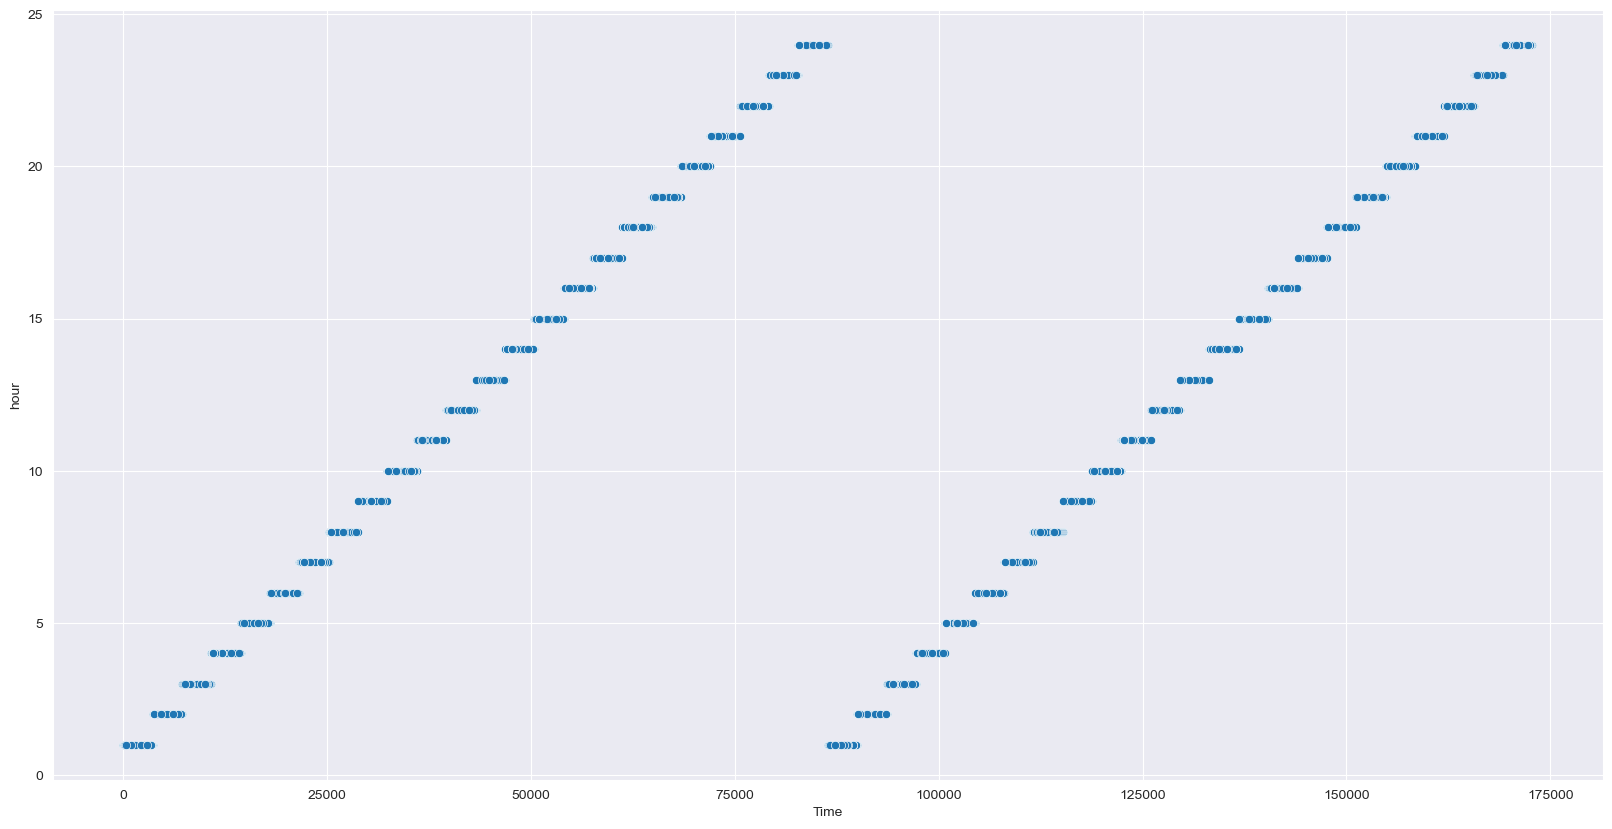

In [117]:
f, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x=train_t['Time'], y=train_t['hour'], data=train_t)

# Feature selection
- Random Forest feature importance
- Logistic Regression with Lasso loss function
- Mutual information
- Forward selection
- Backward selection
- Best subset selection

### Mutual information

Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

In [115]:
from sklearn.feature_selection import mutual_info_regression

In [116]:
# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.columns:
        mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=0)
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
mi_scores = make_mi_scores(X=X_train, y=y_train)

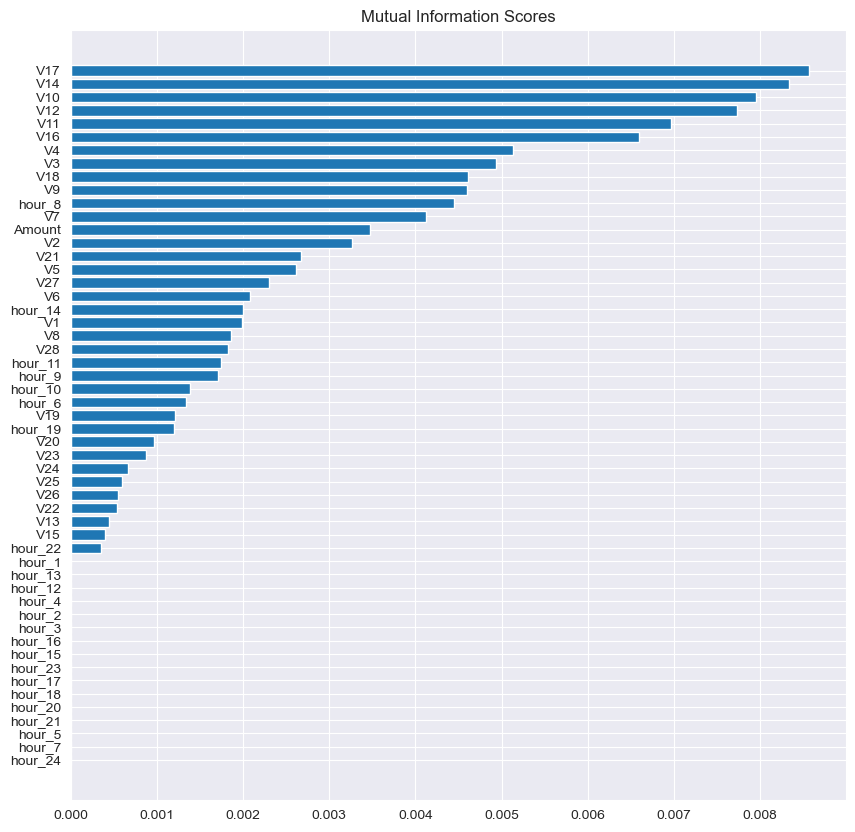

In [437]:
plt.figure(figsize=(10,10))
plot_mi_scores(mi_scores)

### Forward / Backward selection

In [106]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 

##### Forward

In [ ]:
feat_select_model = RandomForestClassifier()
sfs_fwd = SequentialFeatureSelector(feat_select_model, n_features_to_select='auto', direction='forward',\
                                     scoring='f1', cv=3, n_jobs=-1) # ‘recall’, ‘roc_auc’
sfs_fwd.fit(X_train, y_train)

In [ ]:
sfs_fwd.n_features_to_select_

In [ ]:
feature_mask_fwd = sfs_fwd.support_

result_list_fwd = [X_train.columns[i] for i in range(len(X_train.columns)) if feature_mask_fwd[i]]
print(result_list_fwd)

tol=0.02 → ['V10', 'V12', 'V14', 'Amount']

##### Backward

In [ ]:
sfs_bwd = SequentialFeatureSelector(feat_select_model, n_features_to_select='auto', direction='backward',\
                                     scoring='f1', cv=3, n_jobs=-1) # ‘recall’, ‘roc_auc’
sfs_bwd.fit(X_train, y_train)

In [ ]:
sfs_bwd.n_features_to_select_

In [ ]:
feature_mask_bwd = sfs_bwd.support_

result_list_bwd = [X_train.columns[i] for i in range(len(X_train.columns)) if feature_mask_bwd[i]]
print(result_list_bwd)

### Best subset selection

In [93]:
from itertools import combinations
from sklearn.model_selection import cross_val_score

def best_subset(estimator, X, y, max_size=8, cv=5):
    '''Calculates the best model of up to max_size features of X.
   estimator must have a fit and score functions.
   X must be a DataFrame.'''

    n_features = X.shape[1]
    subsets = (combinations(range(n_features), k + 1) 
               for k in range(min(n_features, max_size)))

    best_size_subset = []
    for subsets_k in subsets:  # for each list of subsets of the same size
        best_score = -np.inf
        best_subset = None
        for subset in subsets_k: # for each subset
            estimator.fit(X.iloc[:, list(subset)], y)
            # get the subset with the best score among subsets of the same size
            score = estimator.score(X.iloc[:, list(subset)], y)
            if score > best_score:
                best_score, best_subset = score, subset
        # to compare subsets of different sizes we must use CV
        # first store the best subset of each size
        best_size_subset.append(best_subset)

    # compare best subsets of each size
    best_score = -np.inf
    best_subset = None
    list_scores = []
    for subset in best_size_subset:
        score = cross_val_score(estimator, X.iloc[:, list(subset)], y, cv=cv).mean()
        list_scores.append(score)
        if score > best_score:
            best_score, best_subset = score, subset

    return best_subset, best_score, best_size_subset, list_scores

In [132]:
b_subset, b_score, b_size, b_list_scores = best_subset(feat_select_model, raw_train[:10], y_train[:10], max_size=20, cv=3)

In [ ]:
print(f'Best subset: {b_subset}', end='\n\n')
print(f'Best subset: {b_score}', end='\n\n')
print(f'Best subset: {b_size}', end='\n\n')
print(f'Best subset: {b_list_scores}', end='\n\n')

# Models

In [423]:
lr_bal_clf = LogisticRegression(class_weight='balanced', n_jobs=-1)
lr_bal_clf.fit(X_train, y_train)
y_pred_bal = lr_bal_clf.predict(X_val)
print(metrics.classification_report(y_val, y_pred_bal, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995     56863
           1     0.7949    0.6327    0.7045        98

    accuracy                         0.9991     56961
   macro avg     0.8971    0.8162    0.8520     56961
weighted avg     0.9990    0.9991    0.9990     56961



In [424]:
rf_bal_clf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
rf_bal_clf.fit(X_train, y_train)
y_pred_bal2 = rf_bal_clf.predict(X_val)
print(metrics.classification_report(y_val, y_pred_bal2, digits=4))

              precision    recall  f1-score   support

           0     0.9984    1.0000    0.9992     56863
           1     1.0000    0.0612    0.1154        98

    accuracy                         0.9984     56961
   macro avg     0.9992    0.5306    0.5573     56961
weighted avg     0.9984    0.9984    0.9977     56961



In [426]:
from sklearn.ensemble import GradientBoostingClassifier 
gb_bal_clf = GradientBoostingClassifier()
gb_bal_clf.fit(X_train, y_train)
y_pred_bal3 = gb_bal_clf.predict(X_val)
print(metrics.classification_report(y_val, y_pred_bal3, digits=4))

              precision    recall  f1-score   support

           0     0.9986    0.9996    0.9991     56863
           1     0.4500    0.1837    0.2609        98

    accuracy                         0.9982     56961
   macro avg     0.7243    0.5916    0.6300     56961
weighted avg     0.9977    0.9982    0.9978     56961



In [427]:
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[('lr', lr_bal_clf), ('rf', rf_bal_clf), ('gb', gb_bal_clf)], voting='soft')
eclf1 = eclf1.fit(X_train, y_train)
vote_pred = eclf1.predict(X_val)
print(metrics.classification_report(y_val, vote_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9986    1.0000    0.9993     56863
           1     0.8889    0.1633    0.2759        98

    accuracy                         0.9985     56961
   macro avg     0.9437    0.5816    0.6376     56961
weighted avg     0.9984    0.9985    0.9980     56961



# ------------------POC----------------------------------------- 


In [118]:
# Splitint training data for POC purposes (only about 2 mln instances)

raw_train.shape

(170884, 32)

In [119]:
raw_train.head()

Time     V1     V2     V3     V4     V5     V6     V7     V8  \
109011  71174.000 -2.108  1.173  1.614  0.483  0.067 -0.191  0.191 -1.706   
280683 169683.000  2.314 -1.311 -1.421 -1.724 -1.003 -0.913 -0.899 -0.222   
158318 111127.000  2.105  0.155 -1.403  0.311  0.504 -0.691  0.139 -0.418   
243733 152052.000  2.072 -0.016 -1.311  0.373 -0.063 -1.381  0.244 -0.394   
177016 123008.000  2.046  0.156 -2.007  0.385  0.604 -0.757  0.232 -0.231   

           V9  ...    V22    V23    V24   V25    V26    V27    V28  Amount  \
109011 -0.178  ... -0.389  0.260  0.341 0.400 -0.413 -0.348  0.215  19.990   
280683 -1.658  ...  0.665  0.029 -0.348 0.069  0.074 -0.024 -0.076  15.000   
158318  1.895  ...  0.760 -0.022  0.465 0.403 -0.479 -0.017 -0.054   1.000   
243733  0.631  ...  0.858  0.003  0.077 0.259 -0.110 -0.021 -0.059   1.990   
177016  0.072  ...  1.166 -0.109  0.794 0.377  0.838 -0.075 -0.053   1.570   

        Class  hour  
109011      0    20  
280683      0    24  
158318      0     7  
243733      0    19  
177016      0    11  

[5 rows x 32 columns]

In [140]:
drop_list = ['Class', 'hour']

X_train_poc = raw_train.drop(drop_list, axis=1)
X_train_poc

Time     V1     V2     V3     V4     V5     V6     V7     V8  \
109011  71174.000 -2.108  1.173  1.614  0.483  0.067 -0.191  0.191 -1.706   
280683 169683.000  2.314 -1.311 -1.421 -1.724 -1.003 -0.913 -0.899 -0.222   
158318 111127.000  2.105  0.155 -1.403  0.311  0.504 -0.691  0.139 -0.418   
243733 152052.000  2.072 -0.016 -1.311  0.373 -0.063 -1.381  0.244 -0.394   
177016 123008.000  2.046  0.156 -2.007  0.385  0.604 -0.757  0.232 -0.231   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
3441     2937.000 -0.415  0.713  1.222 -2.108  0.187 -1.282  1.119 -0.345   
233802 147710.000  1.994 -0.517 -0.620  0.130 -0.285  0.395 -0.822  0.232   
85418   60764.000 -1.498  0.658  1.582 -0.024  0.585  1.303  0.609  0.136   
29062   35301.000  1.070  0.072  0.497  1.505 -0.380 -0.370  0.101 -0.027   
17677   28847.000 -0.598  0.775  1.823  0.313 -0.096 -0.391  0.499  0.071   

           V9  ...    V20    V21    V22    V23    V24    V25    V26    V27  \
109011 -0.178  ... -0.809  1.521 -0.389  0.260  0.341  0.400 -0.413 -0.348   
280683 -1.658  ... -0.487  0.089  0.665  0.029 -0.348  0.069  0.074 -0.024   
158318  1.895  ... -0.193  0.108  0.760 -0.022  0.465  0.403 -0.479 -0.017   
243733  0.631  ... -0.260  0.243  0.858  0.003  0.077  0.259 -0.110 -0.021   
177016  0.072  ... -0.112  0.327  1.166 -0.109  0.794  0.377  0.838 -0.075   
...       ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
3441    0.463  ...  0.075  0.133  0.757 -0.291  0.559  0.037 -0.872  0.239   
233802  0.996  ... -0.174  0.263  0.885  0.099  0.276 -0.195  0.624 -0.032   
85418   0.453  ... -0.225 -0.072  0.299  0.110 -0.616 -0.426  0.264 -0.448   
29062   0.320  ... -0.149 -0.062 -0.045 -0.050  0.400  0.593 -0.335  0.031   
17677  -0.017  ...  0.102  0.061  0.568 -0.084  0.685 -0.246  0.357  0.379   

          V28  Amount  
109011  0.215  19.990  
280683 -0.076  15.000  
158318 -0.054   1.000  
243733 -0.059   1.990  
177016 -0.053   1.570  
...       ...     ...  
3441   -0.020   1.000  
233802 -0.059   5.990  
85418   0.045  36.990  
29062   0.025  45.420  
17677   0.206   6.990  

[170884 rows x 30 columns]

In [141]:
print("X_train_poc set dimensions: ", X_train_poc.shape)
print("y_train set dimensions: ", y_train.shape)

X_train_poc set dimensions:  (170884, 30)
y_train set dimensions:  (170884,)


# ------------------------ Training ---------------------

In [413]:
from sklearn.ensemble import RandomForestClassifier

In [415]:
clf = RandomForestClassifier()
clf.fit(X_train_poc, y_train)

RandomForestClassifier()

In [416]:
# to show floats with 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

feature_importances = pd.DataFrame({'feature': X_train_poc.columns, 'importance': clf.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)
print(feature_importances)

   feature  importance
17     V17       0.174
12     V12       0.116
14     V14       0.109
10     V10       0.099
16     V16       0.066
11     V11       0.064
9       V9       0.041
18     V18       0.034
4       V4       0.027
7       V7       0.024
3       V3       0.024
21     V21       0.020
26     V26       0.017
1       V1       0.015
6       V6       0.014
5       V5       0.014
8       V8       0.013
29  Amount       0.012
2       V2       0.011
13     V13       0.011
15     V15       0.011
19     V19       0.011
0     Time       0.011
20     V20       0.011
22     V22       0.010
27     V27       0.010
25     V25       0.008
24     V24       0.008
28     V28       0.008
23     V23       0.007


# ---------Testing and performance analysis---------

### Data preparation

In [417]:
raw_test.head()

Time     V1     V2     V3     V4     V5     V6     V7     V8  \
148361  89763.000  0.288  0.465  1.052 -0.668  0.413 -0.030  0.520 -0.147   
249261 154320.000  1.748 -0.820 -0.086  0.276 -1.067 -0.492 -0.590 -0.087   
87264   61606.000  0.887 -0.374  2.307  3.179 -1.717  0.528 -1.108  0.396   
188431 127974.000 -2.023  2.214 -2.098 -1.042 -0.121 -0.028 -0.595  1.821   
18438   29499.000  1.043  0.011  1.589  2.954 -0.893  0.640 -0.746  0.378   

           V9  ...    V21    V22    V23    V24    V25    V26    V27    V28  \
148361  0.628  ... -0.166 -0.200  0.093  0.575 -0.622 -0.750 -0.082 -0.195   
249261  1.426  ...  0.116  0.300  0.168  0.015 -0.466 -0.109  0.014 -0.009   
87264   1.034  ...  0.156  0.672 -0.087  0.950  0.319  0.192  0.070  0.056   
188431 -0.392  ... -0.202 -0.811  0.165 -0.360 -0.104  0.173  0.061 -0.003   
18438   0.590  ...  0.059  0.513 -0.048  0.415  0.465  0.226  0.059  0.025   

        Amount  Class  
148361   2.490      0  
249261 128.870      0  
87264   72.000      0  
188431   9.990      0  
18438    1.520      0  

[5 rows x 31 columns]

In [418]:
raw_test.shape

(56962, 31)

In [142]:
X_test_poc = raw_test.drop(columns = ['Class'], axis=1) #droppig the same columns as in case of training set
y_test_poc = raw_test['Class'] #getting labels

print(X_test_poc.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


### Predictions

In [451]:
y_pred =clf.predict(X_test_poc)


### Performance analysis

In [421]:
print(metrics.classification_report(y_test_poc, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56863
           1     0.9647    0.8283    0.8913        99

    accuracy                         0.9996     56962
   macro avg     0.9822    0.9141    0.9456     56962
weighted avg     0.9996    0.9996    0.9996     56962



In [452]:
balanced_accuracy_score(y_test_poc, y_pred)

0.9141150349493209

In [422]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred)

### ROC curve

**<code style="background:yellow;color:blue"> FROM THE BOOK </code>**

The roc_curve() function expects labels and scores, but instead of scores you can
give it class probabilities. Let’s use the positive class’s probability as the score:

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class 

In [423]:
y_prob = clf.predict_proba(X_test_poc)[:,1]

In [219]:
from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob)

In [217]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)

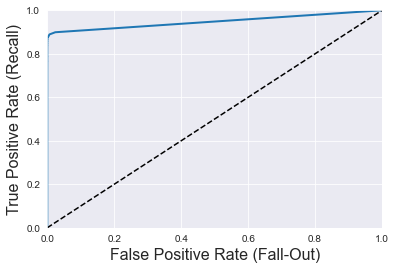

In [426]:
plot_roc_curve(fpr,tpr)
plt.show()

In [427]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_poc, y_prob)

0.9480734041432562

In [428]:
#metrics.ConfusionMatrixDisplay.from_predictions(y_test_poc, y_pred)
#plt.show()

In [215]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(y_test_poc, y_pred)

NameError: name 'y_pred' is not defined

### **<code style="background:lightgreen;color:black"> Observations:</code>** 
  Not bad but still can be better. Especially if it goes to recall on Frauds. 

# -------------------- With hour instead of Time -------------------

In [287]:
drop_list1 = ['Class', 'Time']
X_train_poc1 = train_t.drop(drop_list1, axis=1)
X_train_poc1.head()

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
109011 -2.108  1.173  1.614  0.483  0.067 -0.191  0.191 -1.706 -0.178  0.023   
280683  2.314 -1.311 -1.421 -1.724 -1.003 -0.913 -0.899 -0.222 -1.658  1.890   
158318  2.105  0.155 -1.403  0.311  0.504 -0.691  0.139 -0.418  1.895 -0.501   
243733  2.072 -0.016 -1.311  0.373 -0.063 -1.381  0.244 -0.394  0.631  0.022   
177016  2.046  0.156 -2.007  0.385  0.604 -0.757  0.232 -0.231  0.072 -0.192   

        ...   V21    V22    V23    V24   V25    V26    V27    V28  Amount  \
109011  ... 1.521 -0.389  0.260  0.341 0.400 -0.413 -0.348  0.215  19.990   
280683  ... 0.089  0.665  0.029 -0.348 0.069  0.074 -0.024 -0.076  15.000   
158318  ... 0.108  0.760 -0.022  0.465 0.403 -0.479 -0.017 -0.054   1.000   
243733  ... 0.243  0.858  0.003  0.077 0.259 -0.110 -0.021 -0.059   1.990   
177016  ... 0.327  1.166 -0.109  0.794 0.377  0.838 -0.075 -0.053   1.570   

        hour  
109011    20  
280683    24  
158318     7  
243733    19  
177016    11  

[5 rows x 30 columns]

In [289]:
# one-hot-encoded dataset
X_train_poc1 = pd.get_dummies(X_train_poc1, columns = ['hour'], prefix='hour')
X_train_poc1.head(10)

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
109011 -2.108  1.173  1.614  0.483  0.067 -0.191  0.191 -1.706 -0.178  0.023   
280683  2.314 -1.311 -1.421 -1.724 -1.003 -0.913 -0.899 -0.222 -1.658  1.890   
158318  2.105  0.155 -1.403  0.311  0.504 -0.691  0.139 -0.418  1.895 -0.501   
243733  2.072 -0.016 -1.311  0.373 -0.063 -1.381  0.244 -0.394  0.631  0.022   
177016  2.046  0.156 -2.007  0.385  0.604 -0.757  0.232 -0.231  0.072 -0.192   
76252   1.210  0.005  0.665  0.847 -0.684 -0.654 -0.132 -0.075  0.590 -0.200   
120209 -0.797 -0.556  1.468 -2.465  0.185 -1.288 -0.120 -0.187 -2.779  0.706   
195576 -0.360  0.503 -1.280 -0.112 -0.167 -0.597  1.216  0.266 -0.398 -1.166   
193050 -2.246 -1.757  1.385 -0.281  1.430  1.214  0.020  0.663 -0.159 -1.038   
144159 -2.749  2.126  0.935 -0.069 -1.526 -0.426 -0.644  1.423 -0.184 -0.162   

        ...  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
109011  ...        0        0        0        0        0        1        0   
280683  ...        0        0        0        0        0        0        0   
158318  ...        0        0        0        0        0        0        0   
243733  ...        0        0        0        0        1        0        0   
177016  ...        0        0        0        0        0        0        0   
76252   ...        0        1        0        0        0        0        0   
120209  ...        0        0        0        0        0        0        0   
195576  ...        0        0        0        0        0        0        0   
193050  ...        0        0        0        0        0        0        0   
144159  ...        0        0        0        0        0        0        0   

        hour_22  hour_23  hour_24  
109011        0        0        0  
280683        0        0        1  
158318        0        0        0  
243733        0        0        0  
177016        0        0        0  
76252         0        0        0  
120209        1        0        0  
195576        0        0        0  
193050        0        0        0  
144159        0        0        1  

[10 rows x 53 columns]

In [432]:
clf_s1 = RandomForestClassifier()
clf_s1.fit(X_train_poc1, y_train)

RandomForestClassifier()

In [433]:
# to show floats with 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

feature_importances = pd.DataFrame({'feature': X_train_poc1.columns, 'importance': clf_s1.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)
print(feature_importances)

    feature  importance
16      V17       0.177
11      V12       0.138
13      V14       0.115
15      V16       0.081
9       V10       0.055
10      V11       0.048
8        V9       0.041
3        V4       0.034
17      V18       0.031
6        V7       0.025
1        V2       0.020
2        V3       0.019
25      V26       0.016
20      V21       0.015
4        V5       0.015
7        V8       0.014
19      V20       0.014
18      V19       0.014
26      V27       0.013
14      V15       0.012
0        V1       0.012
5        V6       0.011
28   Amount       0.010
21      V22       0.010
27      V28       0.009
12      V13       0.009
24      V25       0.009
23      V24       0.008
22      V23       0.007
35   hour_7       0.003
37   hour_9       0.002
29   hour_1       0.001
30   hour_2       0.001
46  hour_18       0.001
33   hour_5       0.001
31   hour_3       0.001
50  hour_22       0.001
51  hour_23       0.001
40  hour_12       0.001
42  hour_14       0.001
41  hour_13     

In [290]:
## Test dataset prepareation
raw_test['hour'] = ((((raw_test['Time']) // (60 * 60)) % 24) + 1) # I calculate floor to get hours. As a result I get values from 0 to 47. Next I calulate modulo 24 -> I got values from 0 to 23. Last step adding 1 to get values from 1 to 24.
raw_test['hour'] = raw_test['hour'].astype(int)
print(raw_test['hour'].min(), raw_test['hour'].max())

X_test_poc1 = raw_test.drop(drop_list1, axis=1)
y_test = raw_test['Class']

1 24


In [291]:
# one-hot-encoded dataset
X_test_poc1 = pd.get_dummies(X_test_poc1, columns = ['hour'], prefix='hour')
X_test_poc1.head(10)

V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
148361  0.288  0.465  1.052 -0.668  0.413 -0.030  0.520 -0.147  0.628 -0.643   
249261  1.748 -0.820 -0.086  0.276 -1.067 -0.492 -0.590 -0.087  1.426 -0.306   
87264   0.887 -0.374  2.307  3.179 -1.717  0.528 -1.108  0.396  1.034  0.286   
188431 -2.023  2.214 -2.098 -1.042 -0.121 -0.028 -0.595  1.821 -0.392 -0.234   
18438   1.043  0.011  1.589  2.954 -0.893  0.640 -0.746  0.378  0.590  0.369   
268828 -1.651 -1.022  1.644  0.725  2.470 -1.680 -0.162 -0.124 -0.053 -0.346   
262259  1.919  0.165 -2.046  1.482  0.542 -1.052  0.533 -0.279  0.422 -0.239   
184180  0.175  0.381  0.452 -0.443  0.382 -0.678  1.174 -0.415  0.342 -0.485   
13551  -1.557  0.799  0.856 -0.017  0.541 -1.222  0.517  0.126  0.610 -1.034   
78757   1.486 -0.388  0.188 -0.907 -0.576 -0.475 -0.527 -0.171 -0.816  0.593   

        ...  hour_15  hour_16  hour_17  hour_18  hour_19  hour_20  hour_21  \
148361  ...        0        0        0        0        0        0        0   
249261  ...        0        0        0        0        1        0        0   
87264   ...        0        0        0        1        0        0        0   
188431  ...        0        0        0        0        0        0        0   
18438   ...        0        0        0        0        0        0        0   
268828  ...        0        0        0        0        0        0        0   
262259  ...        0        0        0        0        0        0        1   
184180  ...        0        0        0        0        0        0        0   
13551   ...        0        0        0        0        0        0        0   
78757   ...        0        0        1        0        0        0        0   

        hour_22  hour_23  hour_24  
148361        0        0        0  
249261        0        0        0  
87264         0        0        0  
188431        0        0        0  
18438         0        0        0  
268828        1        0        0  
262259        0        0        0  
184180        0        0        0  
13551         0        0        0  
78757         0        0        0  

[10 rows x 53 columns]

In [436]:
y_pred1 =clf_s1.predict(X_test_poc1)

In [437]:
print(metrics.classification_report(y_test, y_pred1, digits=4))

              precision    recall  f1-score   support

           0     0.9997    1.0000    0.9998     56863
           1     0.9762    0.8283    0.8962        99

    accuracy                         0.9997     56962
   macro avg     0.9879    0.9141    0.9480     56962
weighted avg     0.9997    0.9997    0.9997     56962



In [449]:
balanced_accuracy_score(y_test, y_pred1)

0.9141238280133519

In [438]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred1)

# ---------------- ROC curve--------------------------

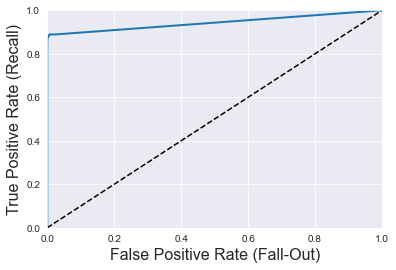

In [439]:
y_prob1 = clf_s1.predict_proba(X_test_poc1)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob1)

plot_roc_curve(fpr,tpr)
plt.show()

In [440]:
roc_auc_score(y_test, y_prob1)

0.9430509658425877

In [441]:
confusion_matrix(y_test, y_pred1)

array([[56861,     2],
       [   17,    82]], dtype=int64)

### Observation:

- it is not better.

NEXT STEPS:
- check the result after removing the 'time' column
- deside which feature shouls stay. Maybe it would be good to run lasso and compare the feature importance from RF and lasso. Based on that maybe it will be possible to deside which features are more important. 


# --------------- Balanced Random Forest --------------

In [442]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train_poc, y_train)

BalancedRandomForestClassifier(random_state=0)

In [443]:
y_pred = brf.predict(X_test_poc)
balanced_accuracy_score(y_test_poc, y_pred)

0.9376682783731304

In [444]:
print(metrics.classification_report(y_test_poc, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9998    0.9763    0.9879     56863
           1     0.0621    0.8990    0.1161        99

    accuracy                         0.9762     56962
   macro avg     0.5309    0.9377    0.5520     56962
weighted avg     0.9982    0.9762    0.9864     56962



In [445]:
precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred)

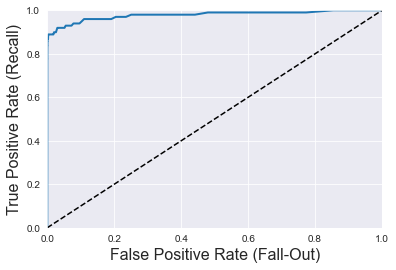

In [446]:
y_prob = brf.predict_proba(X_test_poc)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob)

plot_roc_curve(fpr,tpr)
plt.show()

In [447]:
roc_auc_score(y_test_poc, y_prob)

0.9783640886291117

In [448]:
confusion_matrix(y_test_poc, y_pred)

array([[55518,  1345],
       [   10,    89]], dtype=int64)

# This model could be chosen in an ensemble because it is better at recall but very bad in precision

### -> just to check how the feature importance looks for this model

In [456]:
# to show floats with 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

feature_importances = pd.DataFrame({'feature': X_train_poc.columns, 'importance': brf.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)
print(feature_importances)

   feature  importance
14     V14       0.178
10     V10       0.131
4       V4       0.101
12     V12       0.084
11     V11       0.084
3       V3       0.063
17     V17       0.053
7       V7       0.040
16     V16       0.037
9       V9       0.024
2       V2       0.023
21     V21       0.018
6       V6       0.014
1       V1       0.014
5       V5       0.013
29  Amount       0.012
20     V20       0.012
19     V19       0.011
18     V18       0.010
8       V8       0.009
13     V13       0.009
27     V27       0.008
26     V26       0.008
15     V15       0.007
28     V28       0.007
0     Time       0.006
25     V25       0.006
23     V23       0.005
24     V24       0.005
22     V22       0.005


## Logistic regression

In [122]:
from sklearn.linear_model import LogisticRegression

In [292]:
lr_clf = LogisticRegression(penalty='l1', solver='liblinear')
lr_clf.fit(X_train_poc1, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [293]:
y_pred_lr = lr_clf.predict(X_test_poc1)

In [294]:
log_importance = dict(zip(list(X_test_poc1.columns), lr_clf.coef_.tolist()[0]))

In [295]:
pd.DataFrame(index=log_importance.keys(), data=log_importance.values()).sort_values(0, ascending=False)

0
hour_3    1.966
hour_5    1.243
V4        0.796
V22       0.461
hour_18   0.425
V21       0.347
V24       0.191
V26       0.185
hour_14   0.140
V5        0.135
V12       0.134
V1        0.101
V11       0.083
hour_13   0.048
hour_1    0.027
V3        0.010
Amount    0.001
hour_10   0.000
hour_8    0.000
hour_17   0.000
hour_4    0.000
hour_19   0.000
hour_21   0.000
hour_22   0.000
hour_23   0.000
hour_2    0.000
hour_15   0.000
hour_24   0.000
V25       0.000
V18       0.000
V2        0.000
V6       -0.019
V19      -0.027
hour_20  -0.055
V17      -0.079
V15      -0.081
V23      -0.093
V7       -0.120
V8       -0.147
hour_11  -0.190
hour_12  -0.203
V28      -0.223
V9       -0.230
V16      -0.350
hour_16  -0.391
V13      -0.418
V20      -0.431
V14      -0.613
V27      -0.710
V10      -0.903
hour_9   -1.474
hour_7  -11.020
hour_6  -15.056

In [144]:
print(metrics.classification_report(y_test_poc, y_pred_lr, digits=4))

              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9996     56863
           1     0.8608    0.6869    0.7640        99

    accuracy                         0.9993     56962
   macro avg     0.9301    0.8433    0.8818     56962
weighted avg     0.9992    0.9993    0.9992     56962



In [154]:
precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred_lr)

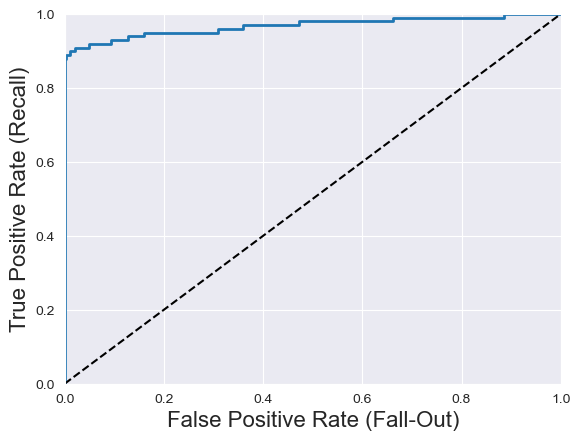

In [174]:
y_prob_lr = lr_clf.predict_proba(X_test_poc)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob_lr)

plot_roc_curve(fpr,tpr)
plt.show()

In [182]:
roc_auc_score(y_test_poc, y_prob_lr)

0.968036235239865

In [170]:
confusion_matrix(y_test_poc, y_pred_lr)

array([[56852,    11],
       [   31,    68]], dtype=int64)

## XGBoost

In [149]:
# pip install xgboost

In [115]:
import xgboost as xgb

In [116]:
xgb_clf = xgb.XGBClassifier()

In [121]:
xgb_clf.fit(raw_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [131]:
xgb_feat_imp = dict(zip(raw_train.columns, xgb_clf.feature_importances_))
pd.DataFrame(data=xgb_feat_imp.values(), index=xgb_feat_imp.keys()).sort_values(0, ascending=False)

0
V17     0.391914
V14     0.063454
V7      0.039673
V10     0.037395
V4      0.034003
V12     0.033133
V1      0.025244
V27     0.024466
V21     0.023888
Amount  0.021643
V9      0.020506
V26     0.019956
V20     0.019626
V3      0.018544
Time    0.018362
V5      0.018104
V28     0.017441
V16     0.016859
V18     0.015733
V13     0.015515
V11     0.015150
V8      0.014550
V22     0.013584
V2      0.012530
V24     0.012499
V23     0.012316
V19     0.012282
V25     0.011384
V6      0.010489
V15     0.009756

In [152]:
y_pred_xgb = xgb_clf.predict(X_test_poc)

In [153]:
print(metrics.classification_report(y_test_poc, y_pred_xgb, digits=4))

              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56863
           1     0.9529    0.8182    0.8804        99

    accuracy                         0.9996     56962
   macro avg     0.9763    0.9091    0.9401     56962
weighted avg     0.9996    0.9996    0.9996     56962



In [162]:
precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred_xgb)

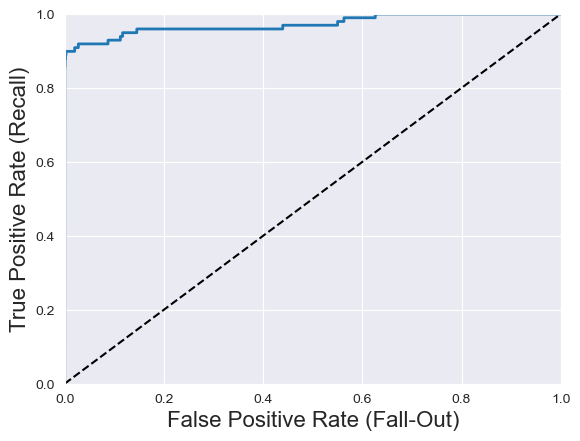

In [179]:
y_prob_xgb = xgb_clf.predict_proba(X_test_poc)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob_xgb)

plot_roc_curve(fpr,tpr)
plt.show()

In [183]:
roc_auc_score(y_test_poc, y_prob_xgb)

0.9727876872944843

In [181]:
confusion_matrix(y_test_poc, y_pred_xgb)

array([[56859,     4],
       [   18,    81]], dtype=int64)

In [ ]:
# Model function

def model_tester(model, X_train, X_val, y, scaled=False, hour=False):
    """The datasets Amount values are not scaled, and the Time column is based on seconds.
    With scaled=True, we will scale the Amount column.
    With hour=True, we will use the hours instead of seconds.
    """
    if scaled==False:
        if hour==True:
            train_t = X_train
            train_t['hour'] = ((((train_t['Time']) // (60 * 60)) % 24) + 1) # I calculate floor to get hours. As a result I get values from 0 to 47. Next I calulate modulo 24 -> I got values from 0 to 23. Last step adding 1 to get values from 1 to 24.
            train_t['hour'] = train_t['hour'].astype(int)
            
            
            
            
model.fit()

### KNN

In [216]:
from sklearn.neighbors import KNeighborsClassifier

In [256]:
knn = KNeighborsClassifier(n_neighbors=4)

In [257]:
knn.fit(X_train_poc, y_train)

KNeighborsClassifier(n_neighbors=4)

In [258]:
y_pred_knn = knn.predict(X_test_poc)

In [259]:
print(metrics.classification_report(y_test_poc, y_pred_knn, digits=4))

              precision    recall  f1-score   support

           0     0.9983    1.0000    0.9992     56863
           1     1.0000    0.0303    0.0588        99

    accuracy                         0.9983     56962
   macro avg     0.9992    0.5152    0.5290     56962
weighted avg     0.9983    0.9983    0.9975     56962



In [260]:
precisions, recalls, thresholds = precision_recall_curve(y_test_poc, y_pred_knn)

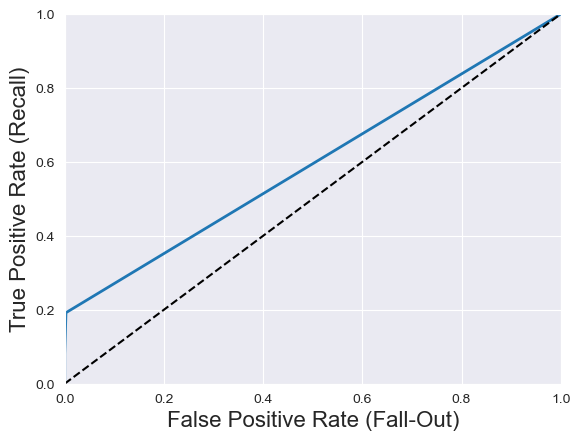

In [261]:
y_prob_knn = knn.predict_proba(X_test_poc)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_poc, y_prob_knn)

plot_roc_curve(fpr,tpr)
plt.show()

In [262]:
roc_auc_score(y_test_poc, y_prob_knn)

0.5948347054954163

In [263]:
confusion_matrix(y_test_poc, y_pred_knn)

array([[56863,     0],
       [   96,     3]], dtype=int64)

## ------ PIPELINE with SAMPLER 

In [152]:
imputer = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()

clean_train = DataCleaner(hour=True, feature_to_drop=[], labels=True, imputer=imputer, scaler=scaler)

In [153]:
X_train, y = clean_train.fit_transform(raw_train)

In [154]:
X_train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'hour'],
      dtype='object')

In [158]:
X_val, y_val = clean_train.transform(raw_val)

In [159]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb 

#xgb_clf = xgb.XGBClassifier()
clf = LogisticRegression(max_iter = 5000, solver='saga')
sampler = RandomOverSampler(random_state=0)
model = make_pipeline(sampler, clf).fit(X_train, y)

In [160]:
y_pred = model.predict(X_val)

In [161]:
print(metrics.classification_report(y_val, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9998    0.9768    0.9881     56863
           1     0.0617    0.8878    0.1155        98

    accuracy                         0.9766     56961
   macro avg     0.5308    0.9323    0.5518     56961
weighted avg     0.9982    0.9766    0.9866     56961



In [163]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_val, y_pred)

0.9322531203713041